In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
from numpy import cos, sin, sqrt, arctan2
import matplotlib.pyplot as plt
import healpy as hp
from healpy.newvisufunc import projview, newprojplot
from astropy import units as u
from astropy.coordinates import SkyCoord
from gwbird import detectors
from gwbird import skymap
from gwbird import utils
from gwbird.overlap import Response
from gwbird.nell import AngularResponse
from gwbird import overlap
from gwbird import nell
from gwbird import skymap
from gwbird import utils
from gwbird import detectors
from gwbird import pls
from gwbird.skymap import Basis, AngularPatternFunction
from gwbird.NANOGrav import NANOGrav_dir
from gwbird.nell import AngularResponse, Sensitivity_ell
import matplotlib.cm as cm


plt.rcParams['figure.dpi'] = 200
REarth = 6.371 * 1e6 #m
c = 3*1e8

# Note: this notebook uses functions that do not include the pulsar terms for transverse polarization modes

In [2]:
# load the pulsar catalog

N, pulsar_xyz, DIST_array = detectors.get_NANOGrav_pulsars()
p = pulsar_xyz
d = DIST_array 

N = int(N/4)


2025-06-12 14:02:28.496 | DEBUG    | pint.models.binary_ddk:validate:211 - Validating DDK model in ECL coordinates


In [3]:
f = np.logspace(-9, -7, 100)

In [7]:
# normalization for tensor modes

for i in range(N):
    print(Response.pairwise_overlap_nopt(f, pulsar_xyz[i], pulsar_xyz[i], float(d[i]), float(d[i]), 't')[0])

0.9999817858017974
0.9999839533116752
0.9999809290618873
0.9999742209994484
0.9999808558598613
0.999977831772839
0.9999783183549013
0.9999799191491313
0.9999829508447702
0.9999811207922388
0.9999786804677643
0.9999676129324997
0.9999816157632055
0.9999761584338897
0.9999758316931526


In [75]:
# normalization for vector modes

for i in range(N):
    print(Response.pairwise_overlap_nopt(f, pulsar_xyz[i], pulsar_xyz[i], float(d[i]), float(d[i]), 'v')[0])

17.907234674617992
13.495461105148886
13.312828172927379
14.149213003330823
40.9894260260249
15.686257896082433
14.644685919857968
16.5133458975547
16.418221346447496
13.096027297426861
96.342278153474
21.58175845122325
15.877112192419153
17.22529736680683
14.350420995343912


In [10]:
# normalization for scalar breathing modes

for i in range(N):
    print(Response.pairwise_overlap_nopt(f, pulsar_xyz[i], pulsar_xyz[i], float(d[i]), float(d[i]), 's')[0])

0.9999817858017974
0.9999839533116751
0.9999809290618873
0.9999742209994489
0.9999808558598606
0.9999778317728392
0.9999783183549009
0.9999799191491313
0.9999829508447702
0.9999811207922389
0.999978680467773
0.9999676129324986
0.9999816157632055
0.9999761584338902
0.9999758316931525


In [13]:
# normalization for scalar longitudinal modes   

for i in range(N):
    print(Response.pairwise_overlap_nopt(f, pulsar_xyz[i], pulsar_xyz[i], float(d[i]), float(d[i]), 'l')[0])

407.59969476237836
451.8252195092165
447.9323142079951
1580.9302343919294
390.84873308271085
248.90713422403704
639.56380521851
873.5638883017116
500.3633266716965
147.87104197286266
175.5212135203885
331.26167958221606
521.2850917879098
476.65291065240103
685.5054270628307


In [14]:
# normalization for circular polarization (has to be zero)

for i in range(N):
    print(Response.pairwise_overlap_nopt(f, pulsar_xyz[i], pulsar_xyz[i], float(d[i]), float(d[i]), 'V')[0])

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


# Overlap Reduction Function

In [80]:
gamma_ij_t = []
gamma_ij_v = []
gamma_ij_s = []
gamma_ij_l = []
gamma_ij_V = []
alpha_ij = []
for i in range(N):
    for j in range(i+1, N):
        alpha_ij.append(np.arccos(np.dot(pulsar_xyz[i], pulsar_xyz[j])))
        gamma_ij_t.append(Response.pairwise_overlap_nopt(f, pulsar_xyz[i], pulsar_xyz[j], d[i], d[j], 't'))
        gamma_ij_v.append(Response.pairwise_overlap_nopt(f, pulsar_xyz[i], pulsar_xyz[j], d[i], d[j],'v'))
        gamma_ij_s.append(Response.pairwise_overlap_nopt(f, pulsar_xyz[i], pulsar_xyz[j], d[i], d[j],'s'))
        gamma_ij_l.append(Response.pairwise_overlap_nopt(f, pulsar_xyz[i], pulsar_xyz[j], d[i], d[j],'l'))
        gamma_ij_V.append(Response.pairwise_overlap_nopt(f, pulsar_xyz[i], pulsar_xyz[j], d[i], d[j],'V'))

gamma_ij_t = np.array(gamma_ij_t)
gamma_ij_v = np.array(gamma_ij_v)
gamma_ij_s = np.array(gamma_ij_s)
gamma_ij_l = np.array(gamma_ij_l)
gamma_ij_V = np.array(gamma_ij_V)
alpha_ij = np.array(alpha_ij)

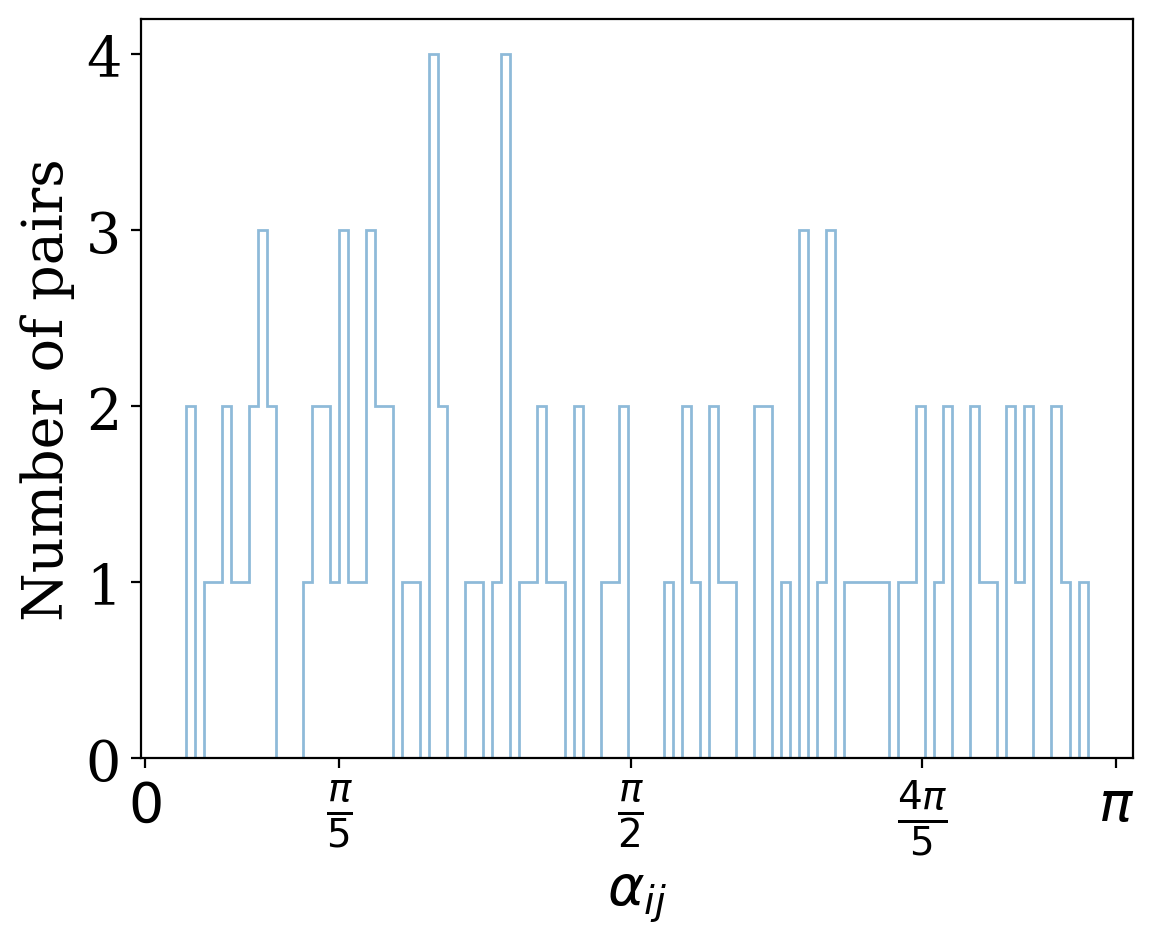

In [39]:
# angular separation between pulsars in radians in a histogram

from matplotlib.ticker import MultipleLocator, FuncFormatter

def custom_pi_formatter(x, pos):
    if x == 0:
        return '0'
    elif x == np.pi / 5:
        return r'$\frac{\pi}{5}$'
    elif x == np.pi / 2:
        return r'$\frac{\pi}{2}$'
    elif x == 4 * np.pi / 5:
        return r'$\frac{4\pi}{5}$'
    elif x == np.pi:
        return r'$\pi$'
    else:
        return ''


# Definire i tick personalizzati
custom_ticks = [0, np.pi / 5, np.pi / 2, 4 * np.pi / 5, np.pi]


plt.hist(alpha_ij, bins=100, histtype='step', alpha=0.5)
plt.xlabel(r'$\alpha_{ij}$')
plt.ylabel('Number of pairs')

#plt.title('Angular separation between pulsars')
plt.xticks(custom_ticks, [r'$0$', r'$\frac{\pi}{5}$', r'$\frac{\pi}{2}$', r'$\frac{4\pi}{5}$', r'$\pi$'])
plt.show()

In [40]:
# hellings  downs curve

def hellings_downs(alpha):
    return 0.5 + (3*(1- np.cos(alpha))/4 * (np.log(0.5*(1-np.cos(alpha)))- 1/6))

def hellings_downs_breathing(alpha):
    return (3 + np.cos(alpha)) / 8

alpha = np.linspace(0.01, np.pi, 100)
hd = hellings_downs(alpha)
hd_breathing = hellings_downs_breathing(alpha)

In [41]:
# find the index corresponding to a frequency of 1e-8

f = np.logspace(-9, -7, 100)
f_index = np.argmin(np.abs(f - 1e-8))
gamma_ij_t_10_8 = gamma_ij_t[:,f_index]
gamma_ij_v_10_8 = gamma_ij_v[:,f_index]
gamma_ij_s_10_8 = gamma_ij_s[:,f_index]
gamma_ij_l_10_8 = gamma_ij_l[:,f_index]
gamma_ij_V_10_8 = gamma_ij_V[:,f_index]


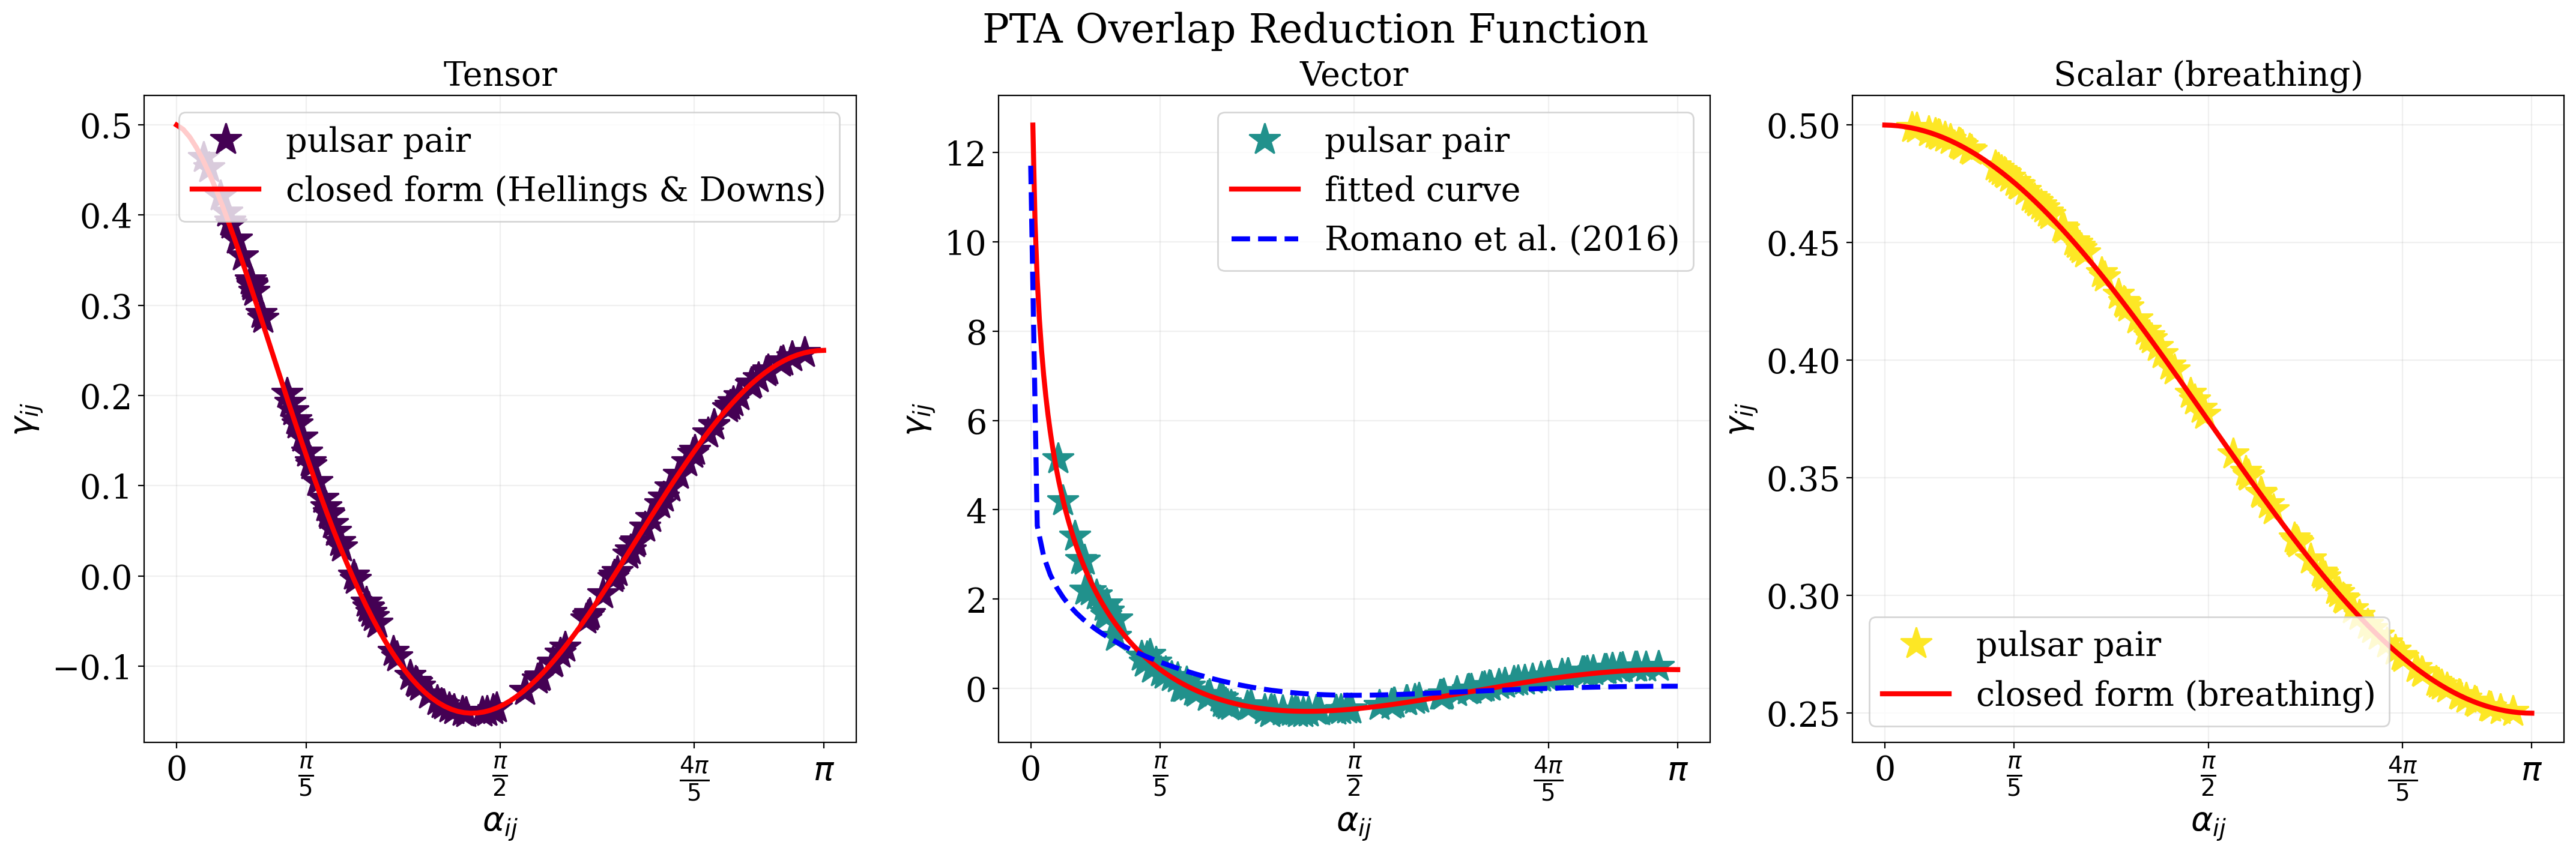

In [81]:
colors = cm.viridis(np.linspace(0, 1, 3))

def model_exp_cos(alpha, A, B, C, D, E):
    return A * np.log(B * alpha) + C * np.cos(D * alpha + E )

def HD_romano(alpha):
    return (1.5* np.log(2/(1-np.cos(alpha)) - 2*np.cos(alpha))- 1.5)/3

alpha_fit = np.linspace(0, np.pi, 300)
gamma_fit_easy = model_exp_cos(alpha_fit, -np.pi, 0.674, -3, 0.813, 2/10)


fig, ax = plt.subplots(1, 3, figsize=(26, 7))

# Tensors
ax[0].plot(alpha_ij, gamma_ij_t_10_8, '*', color=colors[0], label='pulsar pair', ms=20)    
ax[0].plot(alpha, hd, '-', color='red', label='closed form (Hellings & Downs)')
ax[0].set_xlabel(r'$\alpha_{ij}$')
ax[0].set_ylabel(r'$\gamma_{ij}$')
ax[0].grid(which='both', alpha=0.2)
ax[0].set_title('Tensor')
ax[0].set_xticks(custom_ticks)
ax[0].legend()
ax[0].xaxis.set_major_formatter(plt.FuncFormatter(custom_pi_formatter))

# Vectors
ax[1].plot(alpha_ij, gamma_ij_v[:,-1], '*', color=colors[1], label='pulsar pair', ms=20)
ax[1].plot(alpha_fit, gamma_fit_easy, '-', color='red', label='fitted curve')
ax[1].plot(alpha, HD_romano(alpha), '--', color='blue', label='Romano et al. (2016)')
ax[1].set_xlabel(r'$\alpha_{ij}$')
ax[1].set_ylabel(r'$\gamma_{ij}$')
ax[1].grid(which='both', alpha=0.2)
ax[1].set_title('Vector')
ax[1].set_xticks(custom_ticks)
ax[1].legend()
ax[1].xaxis.set_major_formatter(plt.FuncFormatter(custom_pi_formatter))

# Scalars
ax[2].plot(alpha_ij, gamma_ij_s_10_8, '*', color=colors[2], label='pulsar pair', ms=20)
ax[2].plot(alpha, hd_breathing, '-', color='red', label='closed form (breathing)')
ax[2].set_xlabel(r'$\alpha_{ij}$')
ax[2].set_ylabel(r'$\gamma_{ij}$')
ax[2].grid(which='both', alpha=0.2)
ax[2].legend()
ax[2].set_title('Scalar (breathing)')
ax[2].set_xticks(custom_ticks)
ax[2].xaxis.set_major_formatter(plt.FuncFormatter(custom_pi_formatter))


fig.suptitle('PTA Overlap Reduction Function')

plt.show()

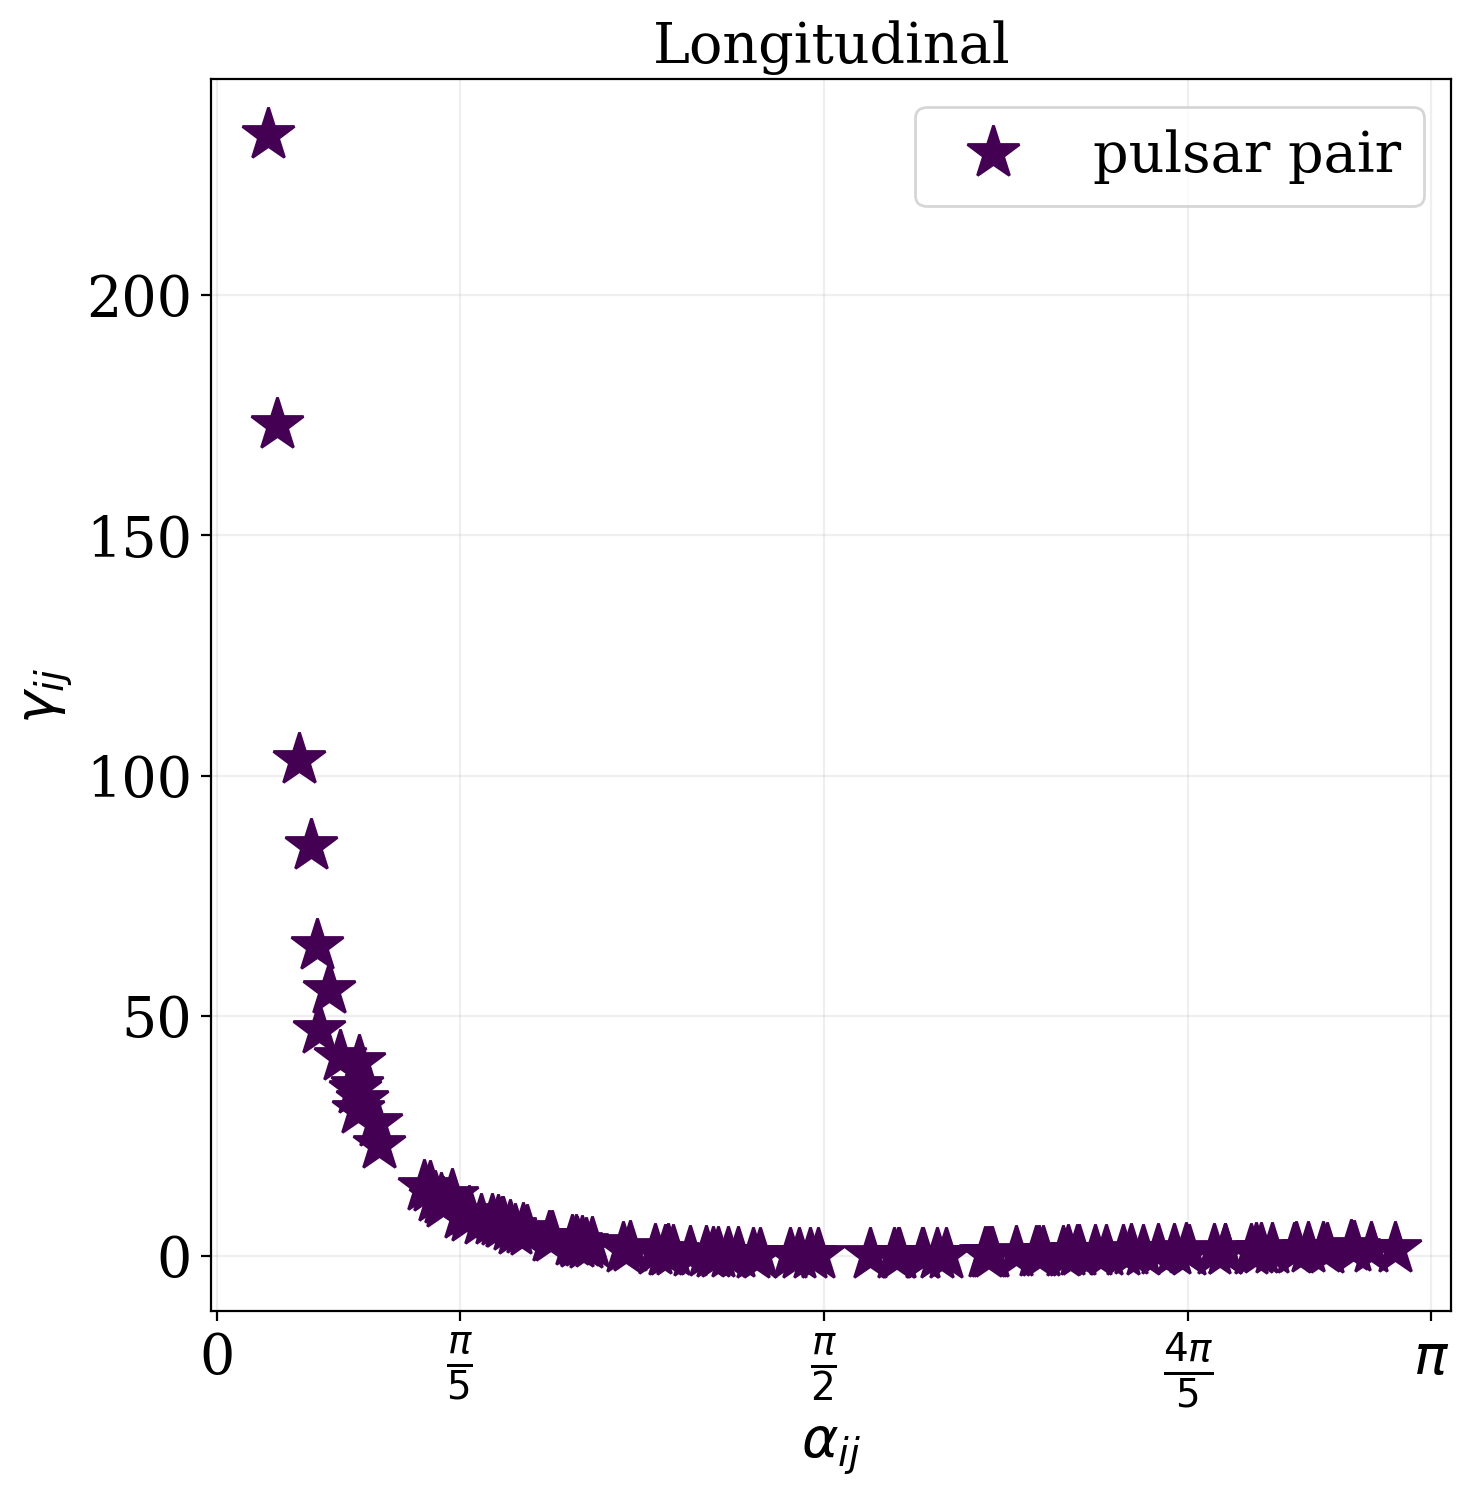

In [46]:
# plot longitudinal

plt.figure(figsize=(8, 8))

plt.plot(alpha_ij, gamma_ij_l_10_8, '*', color=colors[0], label='pulsar pair', ms=20)
plt.xlabel(r'$\alpha_{ij}$')
plt.ylabel(r'$\gamma_{ij}$')
plt.grid(which='both', alpha=0.2)
plt.title('Longitudinal')
plt.xticks(custom_ticks)
plt.legend()
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(custom_pi_formatter))

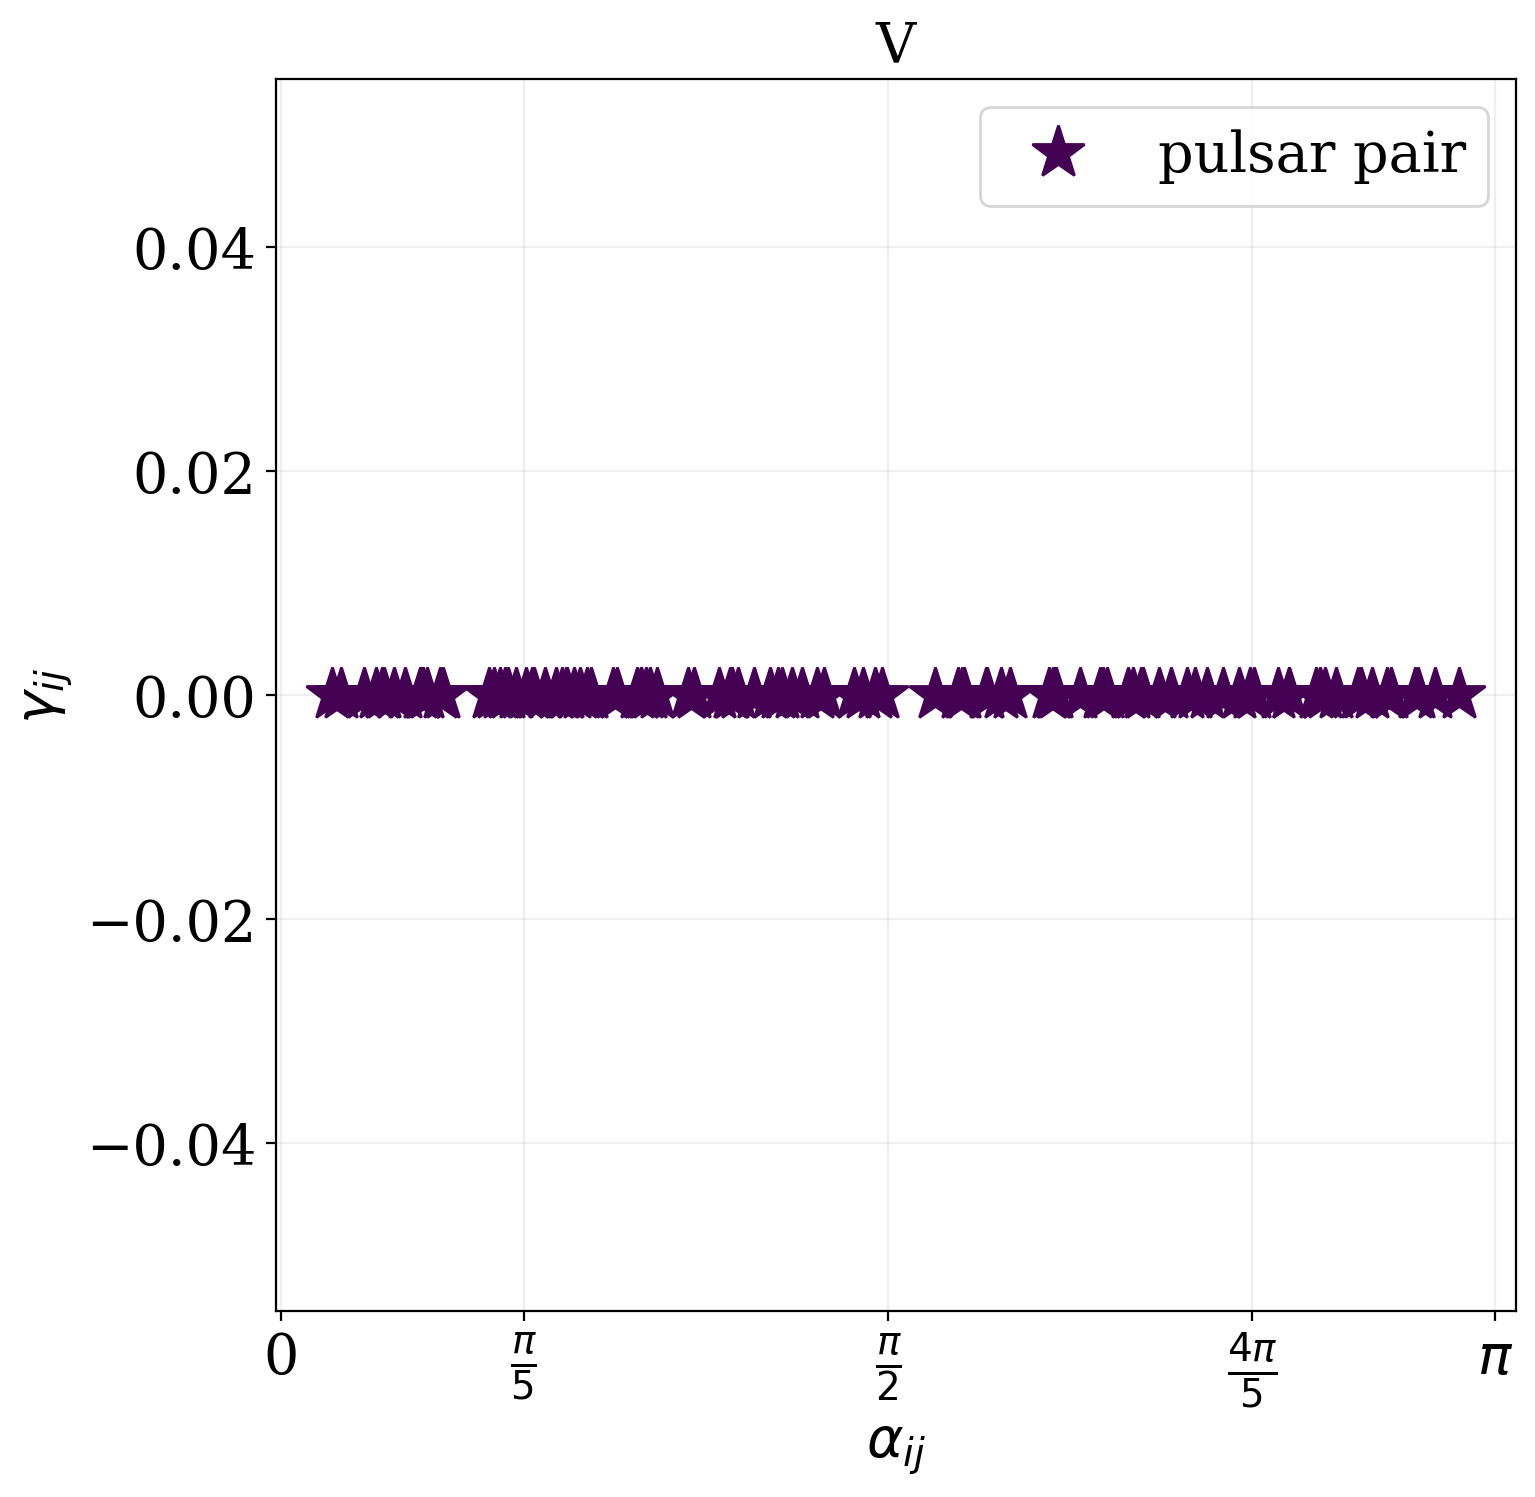

In [48]:
# plot circular

plt.figure(figsize=(8, 8))

plt.plot(alpha_ij, gamma_ij_V_10_8, '*', color=colors[0], label='pulsar pair', ms=20)
plt.xlabel(r'$\alpha_{ij}$')
plt.ylabel(r'$\gamma_{ij}$')
plt.grid(which='both', alpha=0.2)
plt.title('V')
plt.xticks(custom_ticks)
plt.legend()
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(custom_pi_formatter))

vector polarization checks

Minimum alpha: 0.1316246854038818 rad
Minimum alpha: 7.5415389533796375 degrees


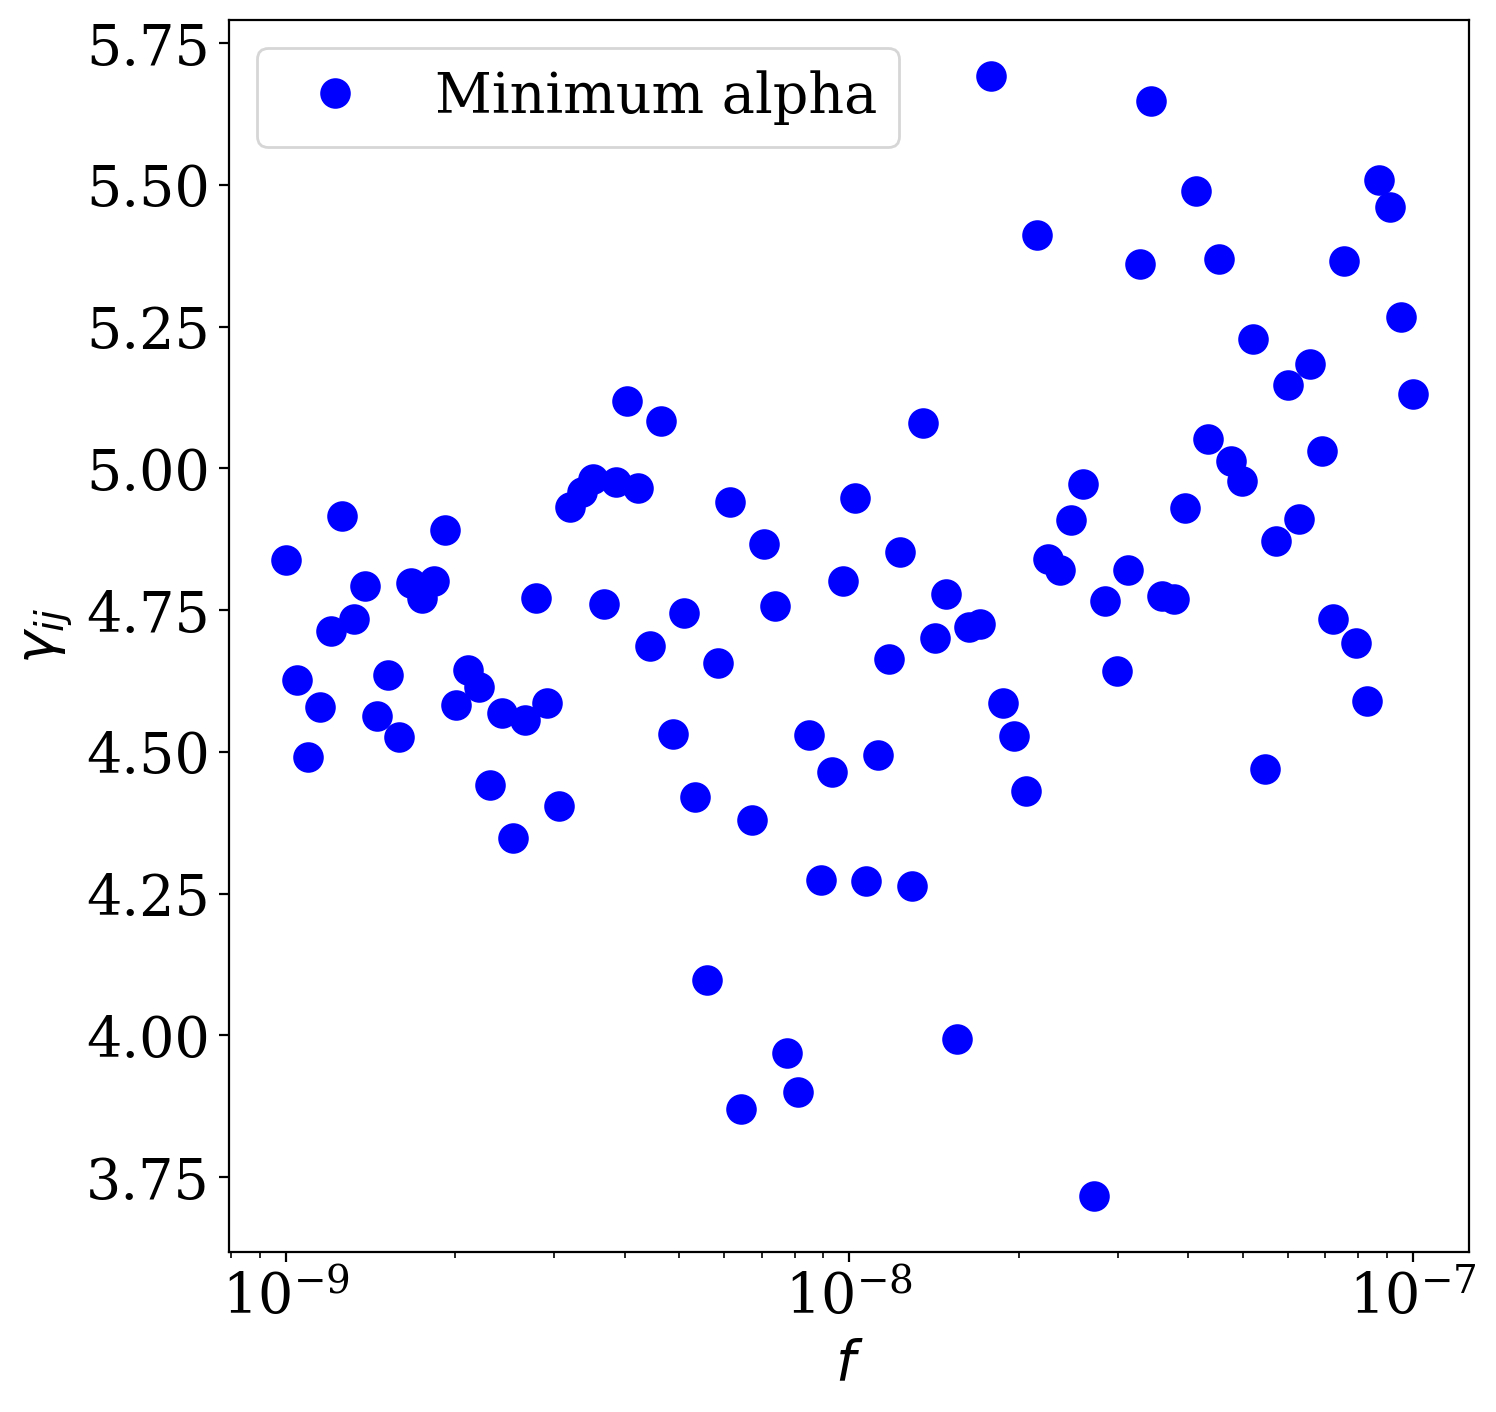

In [85]:
# find the smallest alpha_ij and for that alpha plot gamma_ij_v
min_alpha_index = np.argmin(alpha_ij)
min_alpha = alpha_ij[min_alpha_index]
min_gamma_v = gamma_ij_v[min_alpha_index]

print(f'Minimum alpha: {min_alpha} rad')
# in degrees
min_alpha_deg = np.rad2deg(min_alpha)
print(f'Minimum alpha: {min_alpha_deg} degrees')

# plot the minimum alpha and gamma_v
plt.figure(figsize=(8, 8))
plt.semilogx(f, min_gamma_v, 'o', color='blue', label='Minimum alpha', ms=10)
plt.xlabel(r'$f$')
plt.ylabel(r'$\gamma_{ij}$')

plt.legend()


Minimum alpha: 18.0 degrees


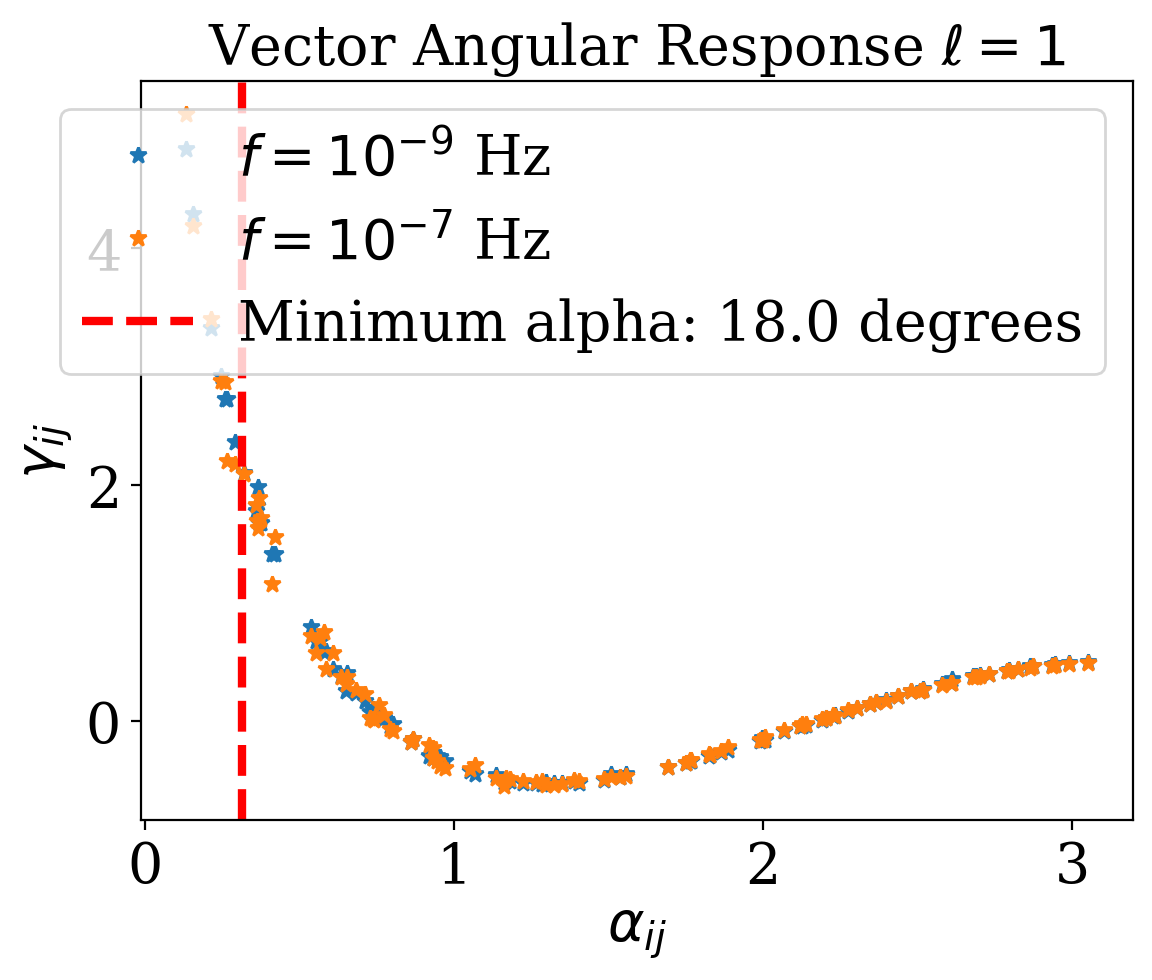

In [88]:
alpha_min = np.pi/10
alpha_min = np.rad2deg(alpha_min)
print(f'Minimum alpha: {alpha_min} degrees')
plt.plot(alpha_ij, gamma_ij_v[:,0], '*', label='$f=10^{-9}$ Hz')
plt.plot(alpha_ij, gamma_ij_v[:,-1], '*', label='$f=10^{-7}$ Hz')
plt.xlabel(r'$\alpha_{ij}$')
plt.ylabel(r'$\gamma_{ij}$')
plt.title('Vector Angular Response $\ell=1$')
# plot a vertical line at alpha_min 
plt.axvline(x=np.pi/10, color='red', linestyle='--', label=f'Minimum alpha: {alpha_min} degrees')
plt.legend()
plt.show()

$\gamma_{ij}^{\ell}$ as a function of the angular separation between pulsars for tensor, vector and scalar (breathing) polarization modes

In [54]:
gamma1_ij_t = []
gamma1_ij_v = []
gamma1_ij_s = []
gamma1_ij_l = []
gamma1_ij_V = []
alpha_ij = []
ell=1
psi = 0
for i in range(N):
    for j in range(i+1, N):
        alpha_ij.append(np.arccos(np.dot(pulsar_xyz[i], pulsar_xyz[j])))
        gamma1_ij_t.append(AngularResponse.R_ell_pairwise_nopt(ell, pulsar_xyz[i], pulsar_xyz[j], d[i], d[j], f, 't', psi))
        gamma1_ij_v.append(AngularResponse.R_ell_pairwise_nopt(ell, pulsar_xyz[i], pulsar_xyz[j], d[i], d[j], f, 'v', psi))
        gamma1_ij_s.append(AngularResponse.R_ell_pairwise_nopt(ell, pulsar_xyz[i], pulsar_xyz[j], d[i], d[j], f, 's', psi))
        gamma1_ij_l.append(AngularResponse.R_ell_pairwise_nopt(ell, pulsar_xyz[i], pulsar_xyz[j], d[i], d[j], f, 'l', psi))
        gamma1_ij_V.append(AngularResponse.R_ell_pairwise_nopt(ell, pulsar_xyz[i], pulsar_xyz[j], d[i], d[j], f, 'V', psi))

gamma1_ij_t = np.array(gamma1_ij_t)
gamma1_ij_v = np.array(gamma1_ij_v)
gamma1_ij_s = np.array(gamma1_ij_s)
gamma1_ij_l = np.array(gamma1_ij_l)
gamma1_ij_V = np.array(gamma1_ij_V) 
alpha_ij = np.array(alpha_ij)

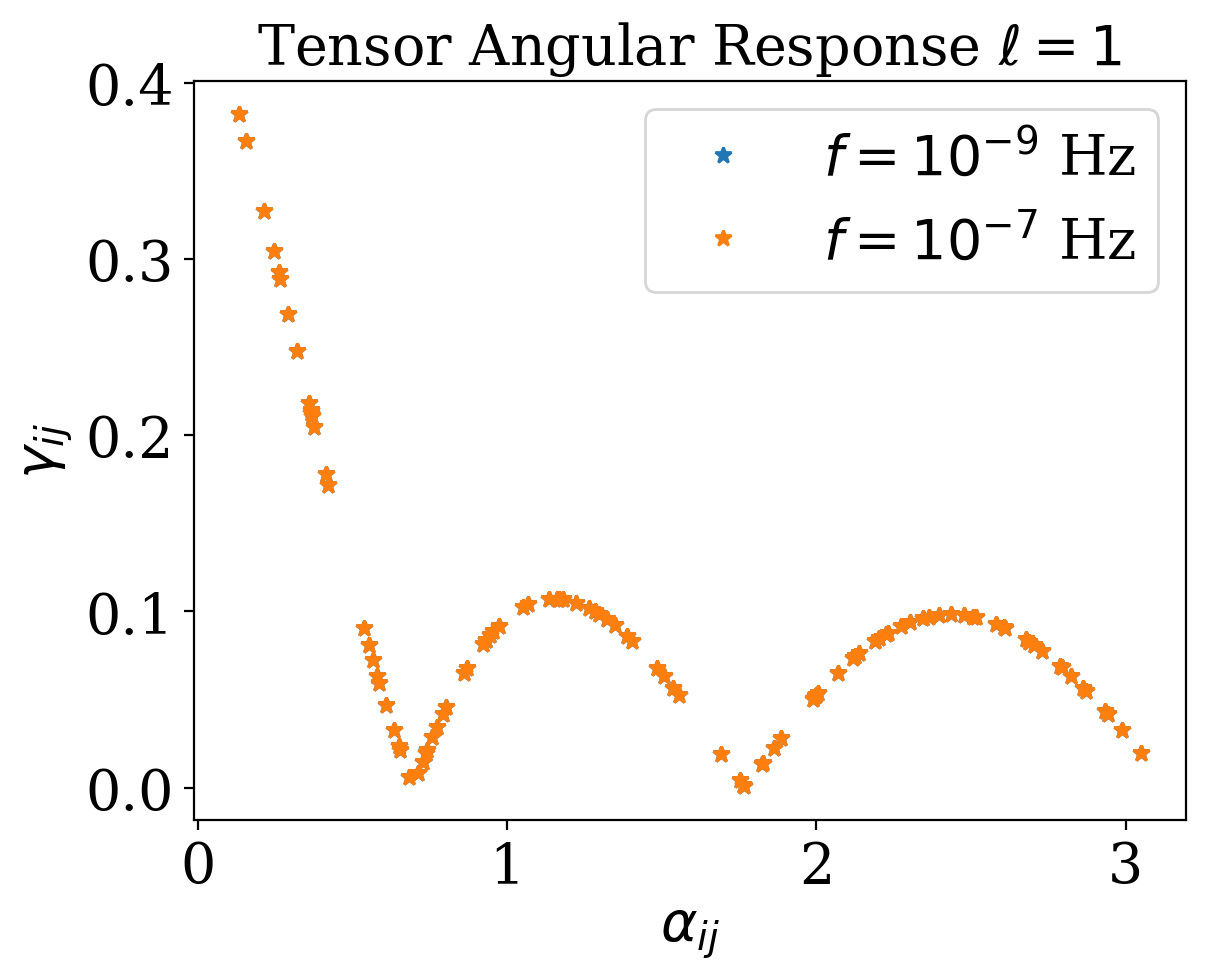

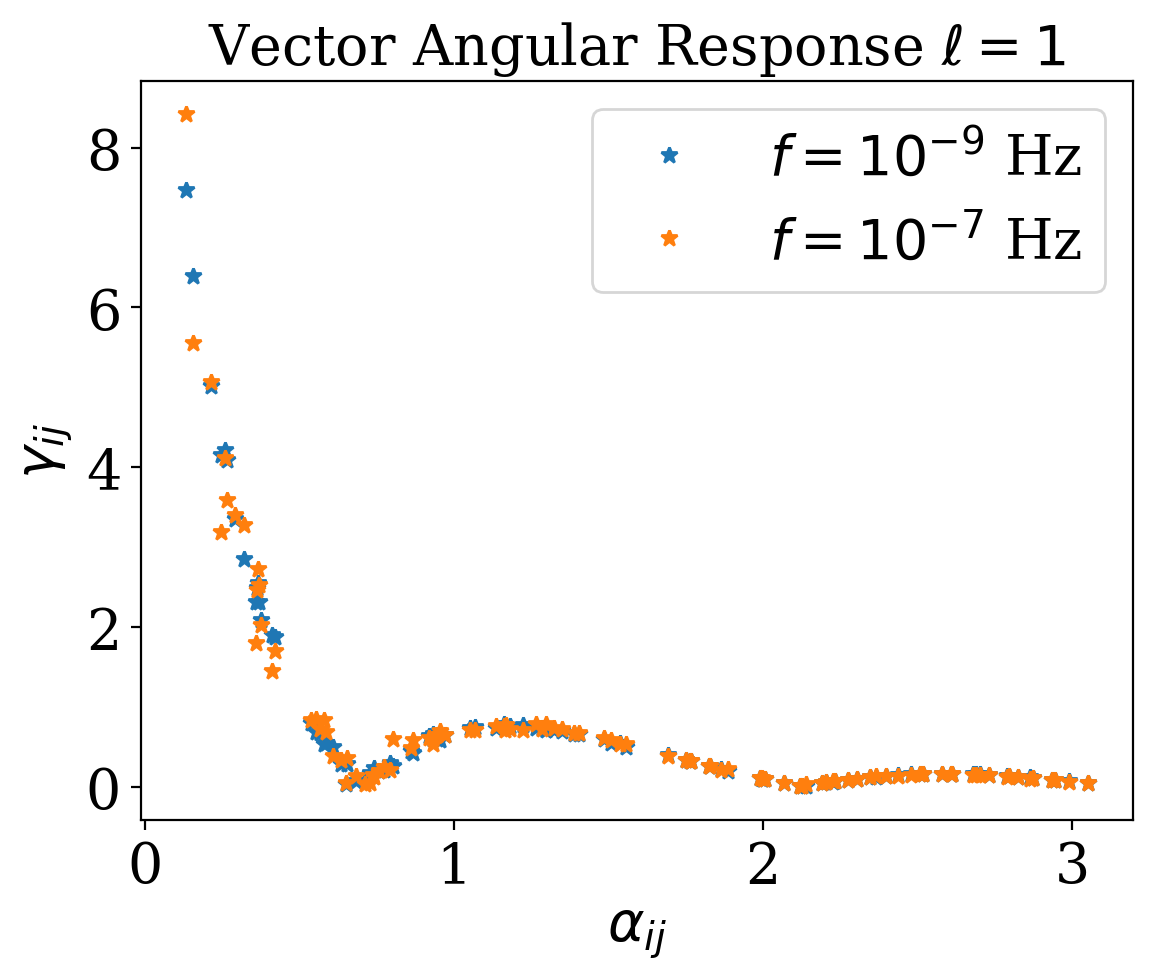

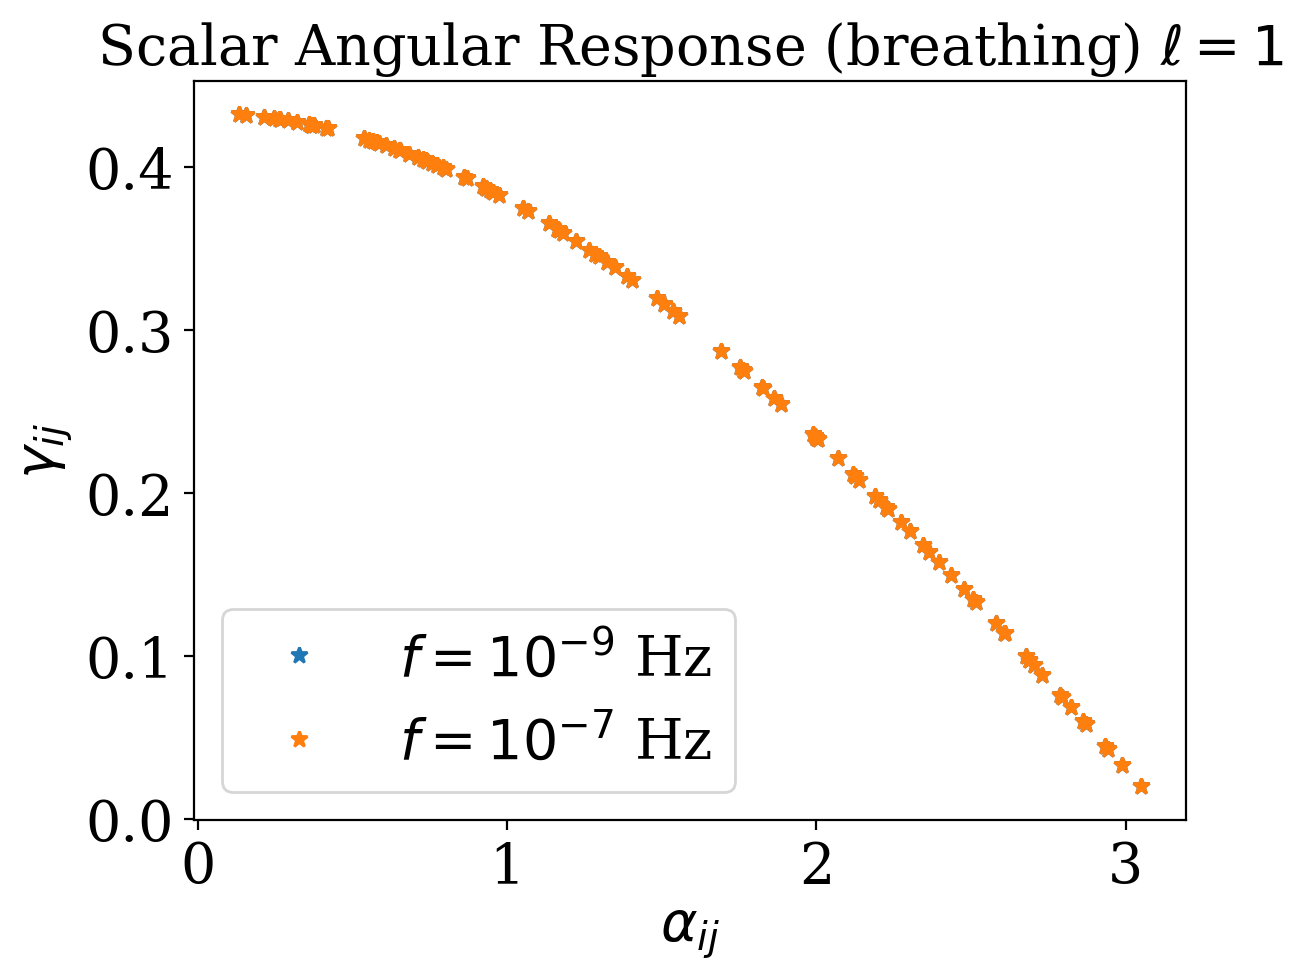

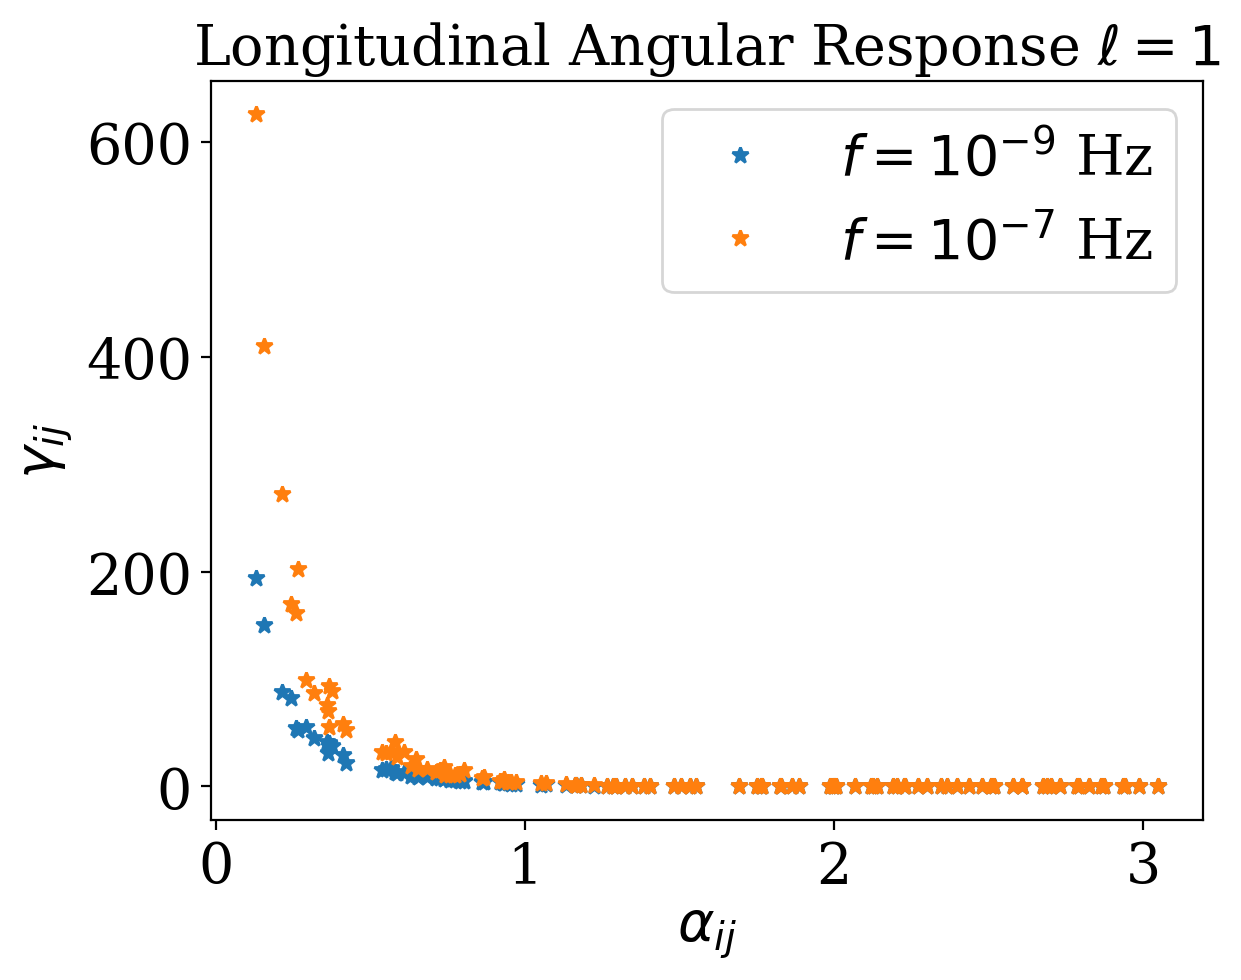

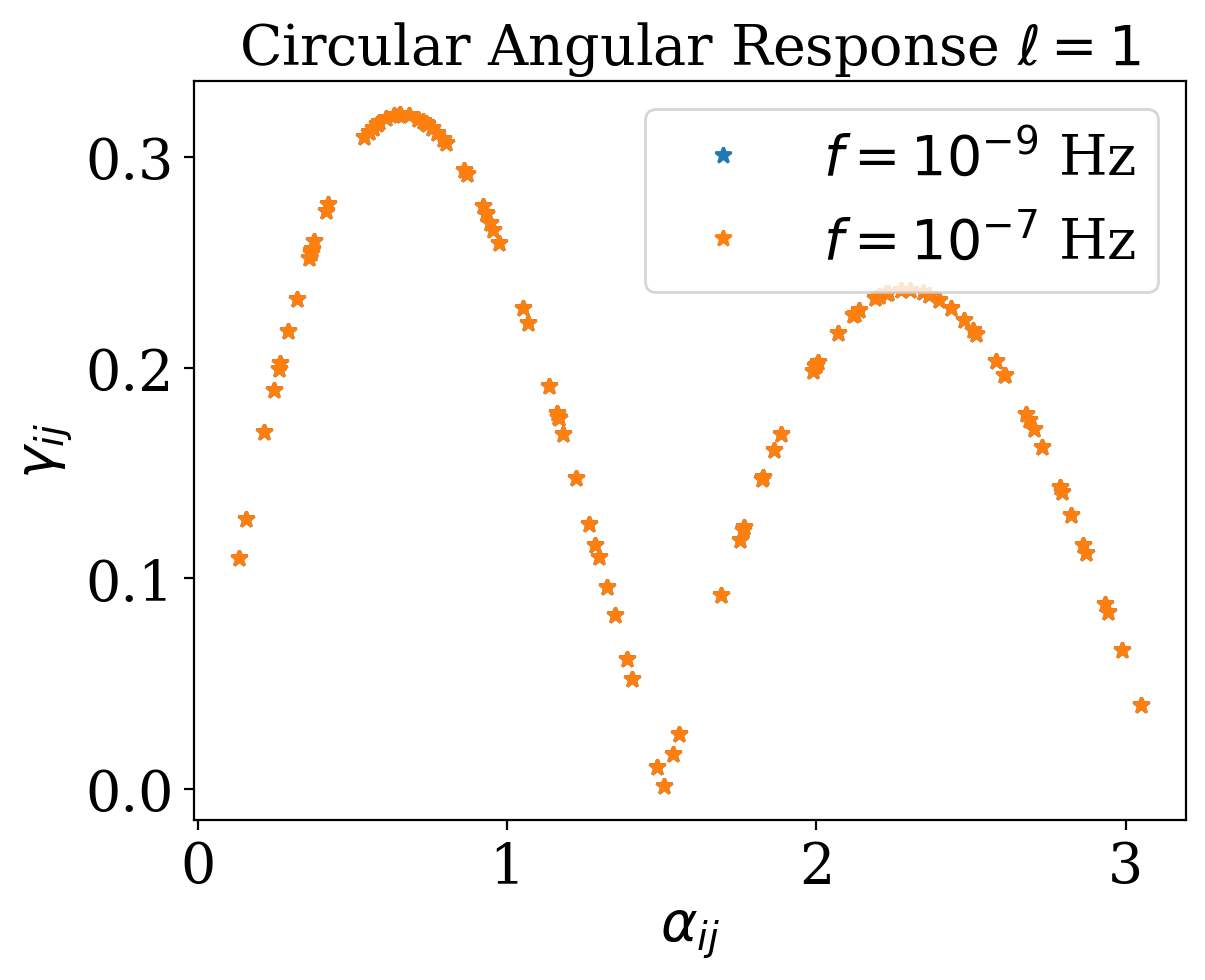

In [55]:
plt.plot(alpha_ij, gamma1_ij_t[:,0], '*', label='$f=10^{-9}$ Hz')
plt.plot(alpha_ij, gamma1_ij_t[:,-1], '*', label='$f=10^{-7}$ Hz')
plt.xlabel(r'$\alpha_{ij}$')
plt.ylabel(r'$\gamma_{ij}$')
plt.title('Tensor Angular Response $\ell=1$')
plt.legend()
plt.show()

plt.plot(alpha_ij, gamma1_ij_v[:,0], '*', label='$f=10^{-9}$ Hz')
plt.plot(alpha_ij, gamma1_ij_v[:,-1], '*', label='$f=10^{-7}$ Hz')
plt.xlabel(r'$\alpha_{ij}$')
plt.ylabel(r'$\gamma_{ij}$')
plt.title('Vector Angular Response $\ell=1$')
plt.legend()
plt.show()

plt.plot(alpha_ij, gamma1_ij_s[:,0], '*', label='$f=10^{-9}$ Hz')
plt.plot(alpha_ij, gamma1_ij_s[:,-1], '*', label='$f=10^{-7}$ Hz')
plt.xlabel(r'$\alpha_{ij}$')
plt.ylabel(r'$\gamma_{ij}$')
plt.title('Scalar Angular Response (breathing) $\ell=1$')
plt.legend()
plt.show()

plt.plot(alpha_ij, gamma1_ij_l[:,0], '*', label='$f=10^{-9}$ Hz')
plt.plot(alpha_ij, gamma1_ij_l[:,-1], '*', label='$f=10^{-7}$ Hz')
plt.xlabel(r'$\alpha_{ij}$')
plt.ylabel(r'$\gamma_{ij}$')
plt.title('Longitudinal Angular Response $\ell=1$')
plt.legend()
plt.show()

plt.plot(alpha_ij, gamma1_ij_V[:,0], '*', label='$f=10^{-9}$ Hz')
plt.plot(alpha_ij, gamma1_ij_V[:,-1], '*', label='$f=10^{-7}$ Hz')
plt.xlabel(r'$\alpha_{ij}$')
plt.ylabel(r'$\gamma_{ij}$')
plt.title('Circular Angular Response $\ell=1$')
plt.legend()
plt.show()

In [56]:
gamma2_ij_t = []
gamma2_ij_v = []
gamma2_ij_s = []
gamma2_ij_l = []
gamma2_ij_V = []
alpha_ij = []
ell=2
psi = 0
for i in range(N):
    for j in range(i+1, N):
        alpha_ij.append(np.arccos(np.dot(pulsar_xyz[i], pulsar_xyz[j])))
        gamma2_ij_t.append(AngularResponse.R_ell_pairwise_nopt(ell, pulsar_xyz[i], pulsar_xyz[j],  d[i], d[j], f, 't', psi))
        gamma2_ij_v.append(AngularResponse.R_ell_pairwise_nopt(ell, pulsar_xyz[i], pulsar_xyz[j],  d[i], d[j],f, 'v', psi))
        gamma2_ij_s.append(AngularResponse.R_ell_pairwise_nopt(ell, pulsar_xyz[i], pulsar_xyz[j],  d[i], d[j],f, 's', psi))
        gamma2_ij_l.append(AngularResponse.R_ell_pairwise_nopt(ell, pulsar_xyz[i], pulsar_xyz[j],  d[i], d[j],f, 'l', psi))
        gamma2_ij_V.append(AngularResponse.R_ell_pairwise_nopt(ell, pulsar_xyz[i], pulsar_xyz[j],  d[i], d[j],f, 'V', psi))

gamma2_ij_t = np.array(gamma2_ij_t)
gamma2_ij_v = np.array(gamma2_ij_v)
gamma2_ij_s = np.array(gamma2_ij_s)
gamma2_ij_l = np.array(gamma2_ij_l)
gamma2_ij_V = np.array(gamma2_ij_V)
alpha_ij = np.array(alpha_ij)


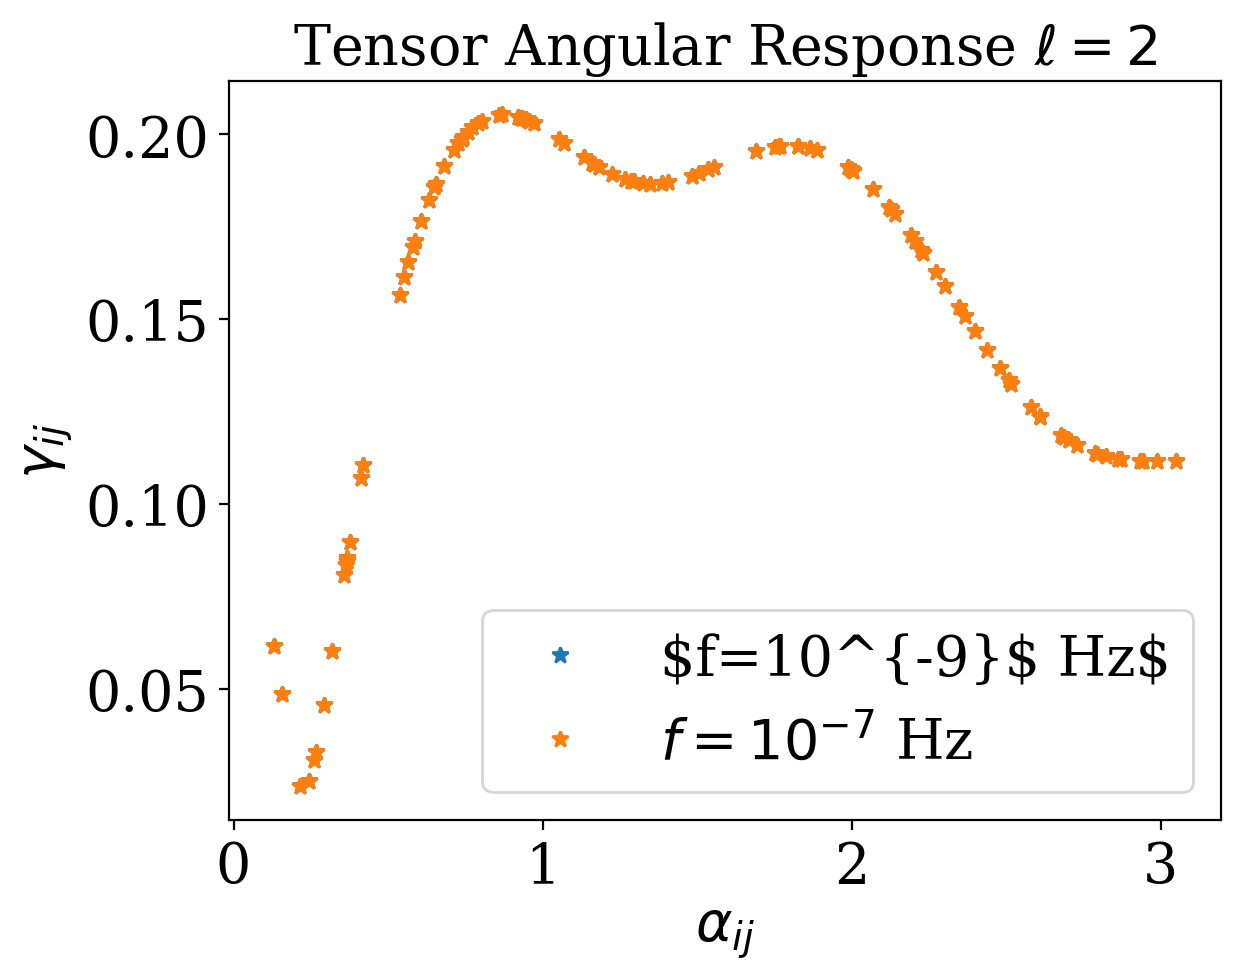

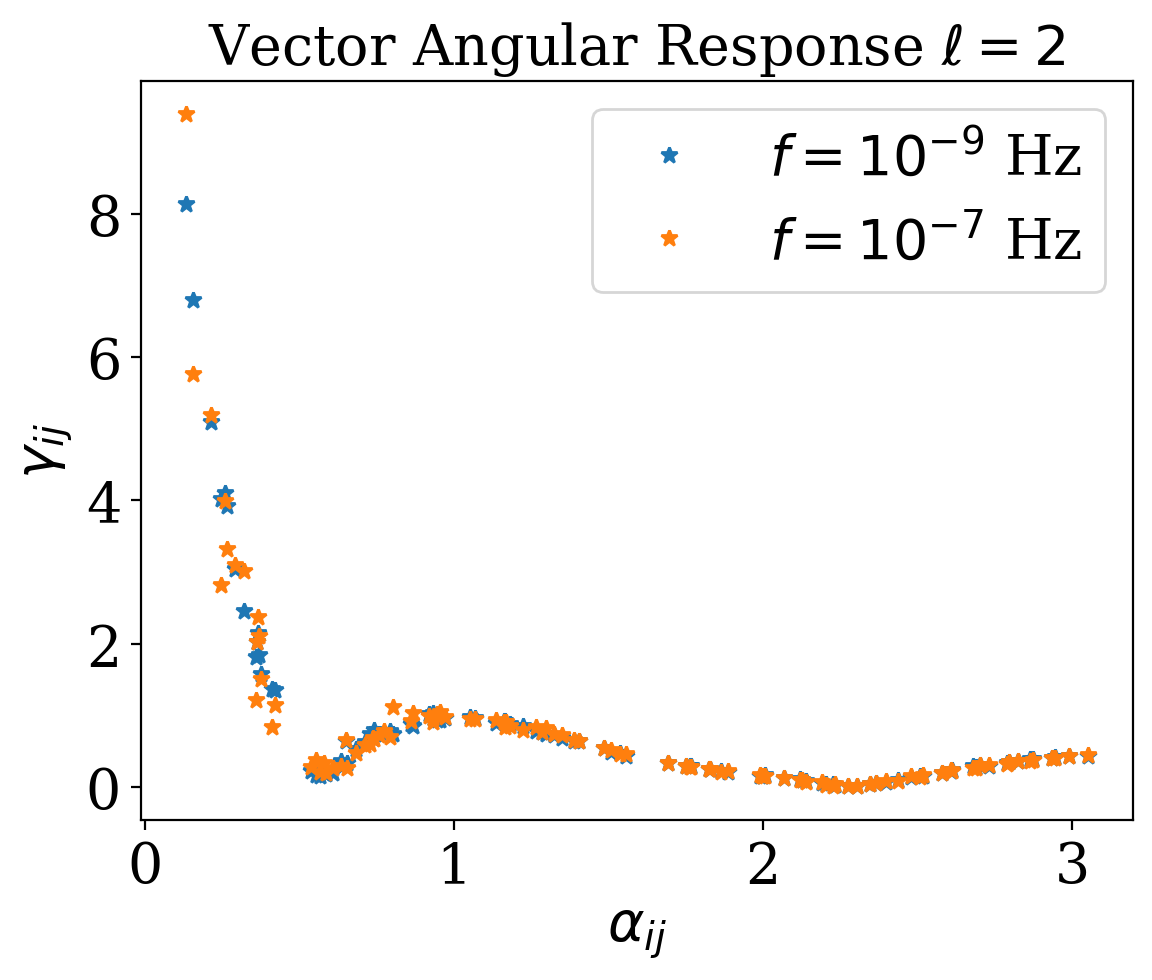

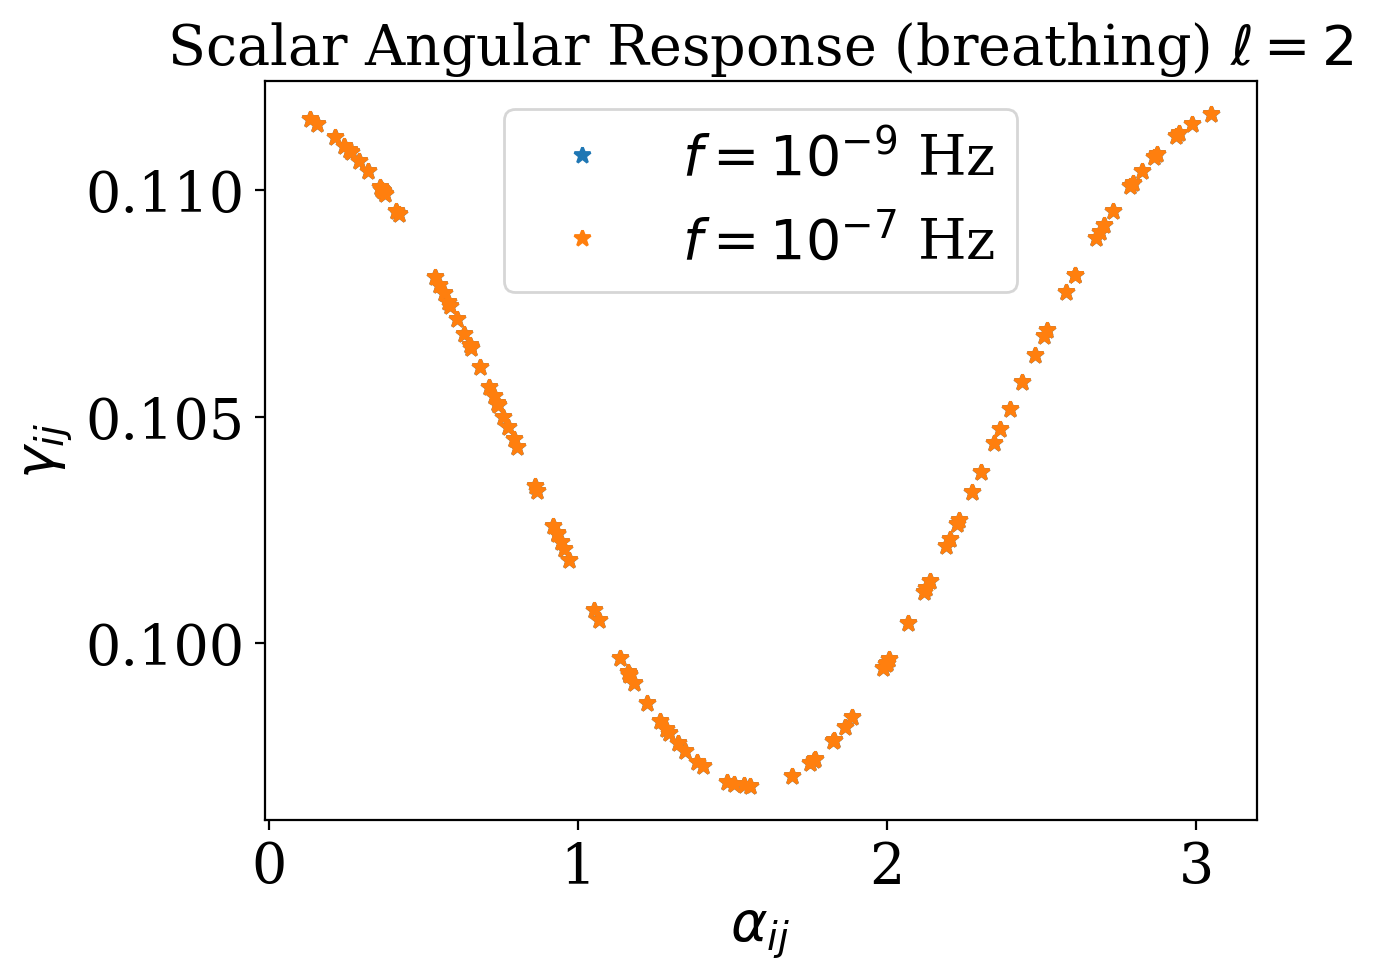

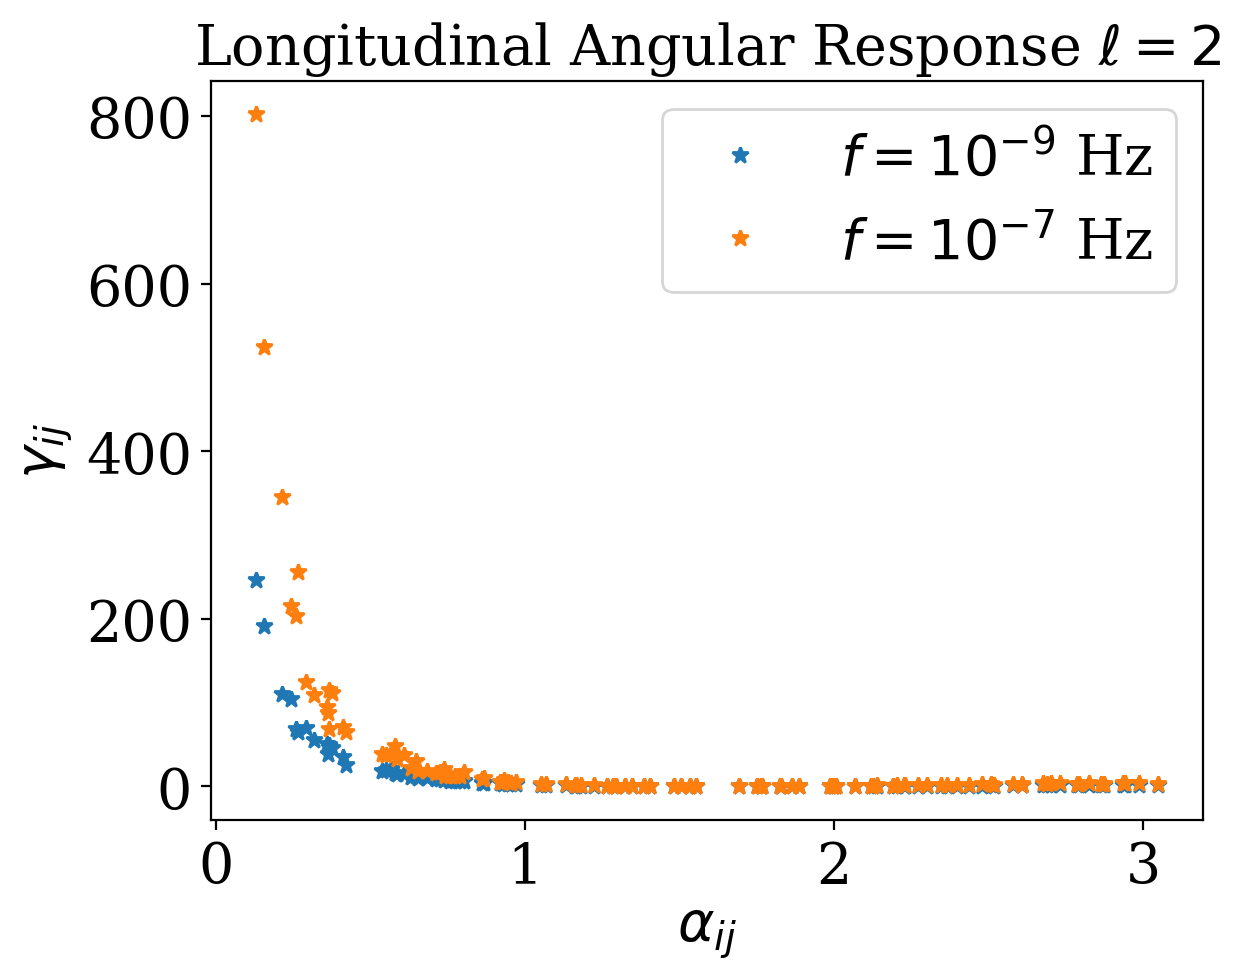

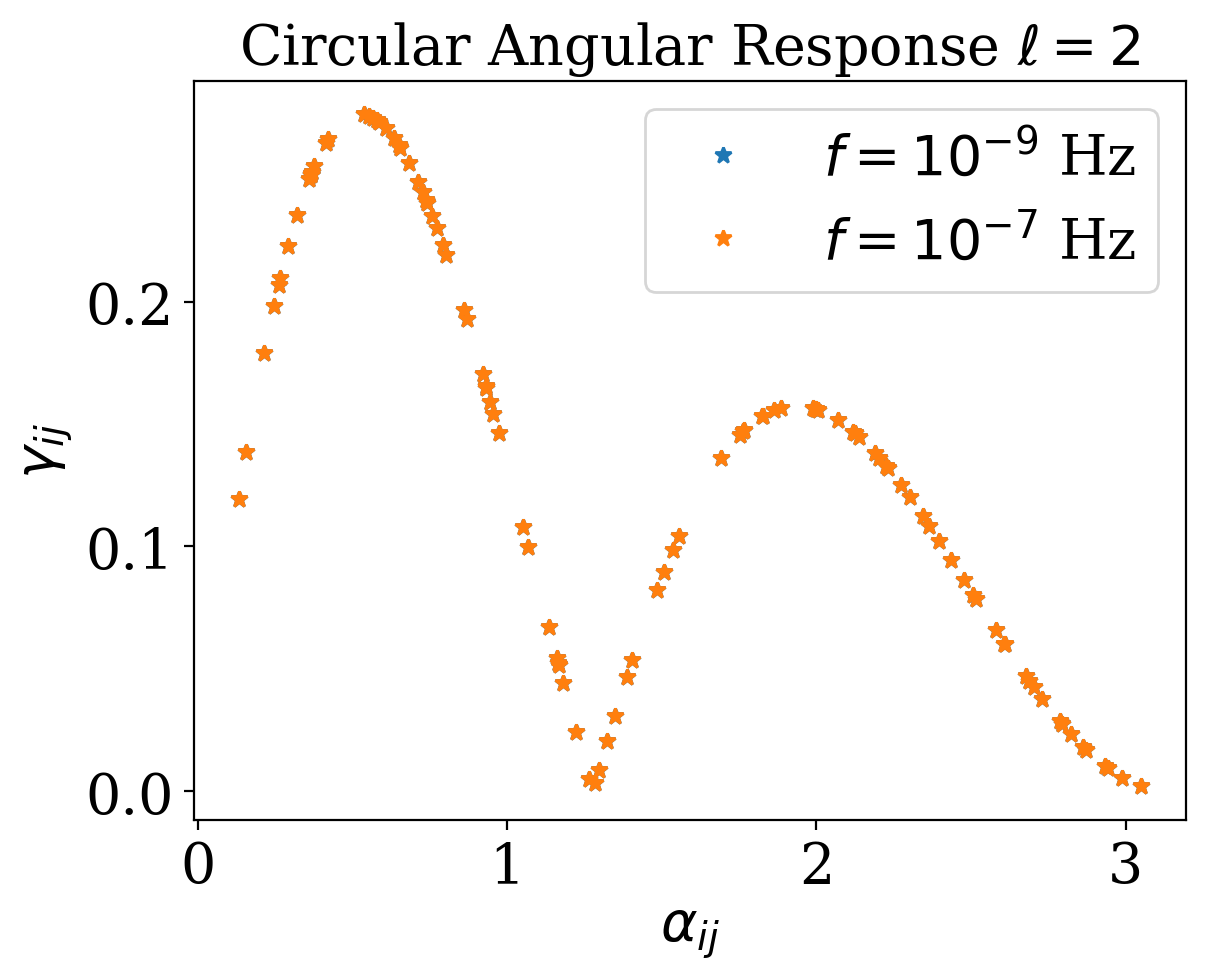

In [57]:
plt.plot(alpha_ij, gamma2_ij_t[:,0], '*', label='$f=10^{-9}$ Hz$')
plt.plot(alpha_ij, gamma2_ij_t[:,-1], '*', label='$f=10^{-7}$ Hz')
plt.xlabel(r'$\alpha_{ij}$')
plt.ylabel(r'$\gamma_{ij}$')
plt.title('Tensor Angular Response $\ell=2$')
plt.legend()
plt.show()

plt.plot(alpha_ij, gamma2_ij_v[:,0], '*', label='$f=10^{-9}$ Hz')
plt.plot(alpha_ij, gamma2_ij_v[:,-1], '*', label='$f=10^{-7}$ Hz')
plt.xlabel(r'$\alpha_{ij}$')
plt.ylabel(r'$\gamma_{ij}$')
plt.title('Vector Angular Response $\ell=2$')
plt.legend()
plt.show()

plt.plot(alpha_ij, gamma2_ij_s[:,0], '*', label='$f=10^{-9}$ Hz')
plt.plot(alpha_ij, gamma2_ij_s[:,-1], '*', label='$f=10^{-7}$ Hz')
plt.xlabel(r'$\alpha_{ij}$')
plt.ylabel(r'$\gamma_{ij}$')
plt.title('Scalar Angular Response (breathing) $\ell=2$')
plt.legend()
plt.show()

plt.plot(alpha_ij, gamma2_ij_l[:,0], '*', label='$f=10^{-9}$ Hz')
plt.plot(alpha_ij, gamma2_ij_l[:,-1], '*', label='$f=10^{-7}$ Hz')
plt.xlabel(r'$\alpha_{ij}$')
plt.ylabel(r'$\gamma_{ij}$')
plt.title('Longitudinal Angular Response $\ell=2$')
plt.legend()
plt.show()

plt.plot(alpha_ij, gamma2_ij_V[:,0], '*', label='$f=10^{-9}$ Hz')
plt.plot(alpha_ij, gamma2_ij_V[:,-1], '*', label='$f=10^{-7}$ Hz')
plt.xlabel(r'$\alpha_{ij}$')
plt.ylabel(r'$\gamma_{ij}$')
plt.title('Circular Angular Response $\ell=2$')
plt.legend()
plt.show()

In [59]:
gamma3_ij_t = []
gamma3_ij_v = []
gamma3_ij_s = []
gamma3_ij_l = []
gamma3_ij_V = []
alpha_ij = []
ell=3
psi = 0
for i in range(N):
    for j in range(i+1, N):
        alpha_ij.append(np.arccos(np.dot(pulsar_xyz[i], pulsar_xyz[j])))
        gamma3_ij_t.append(AngularResponse.R_ell_pairwise_nopt(ell, pulsar_xyz[i], pulsar_xyz[j], d[i], d[j], f, 't', psi))
        gamma3_ij_v.append(AngularResponse.R_ell_pairwise_nopt(ell, pulsar_xyz[i], pulsar_xyz[j], d[i], d[j],f, 'v', psi))
        gamma3_ij_s.append(AngularResponse.R_ell_pairwise_nopt(ell, pulsar_xyz[i], pulsar_xyz[j], d[i], d[j],f, 's', psi))
        gamma3_ij_l.append(AngularResponse.R_ell_pairwise_nopt(ell, pulsar_xyz[i], pulsar_xyz[j], d[i], d[j],f, 'l', psi))
        gamma3_ij_V.append(AngularResponse.R_ell_pairwise_nopt(ell, pulsar_xyz[i], pulsar_xyz[j], d[i], d[j],f, 'V', psi))

gamma3_ij_t = np.array(gamma3_ij_t)
gamma3_ij_v = np.array(gamma3_ij_v)
gamma3_ij_s = np.array(gamma3_ij_s)
gamma3_ij_l = np.array(gamma3_ij_l)
gamma3_ij_V = np.array(gamma3_ij_V)

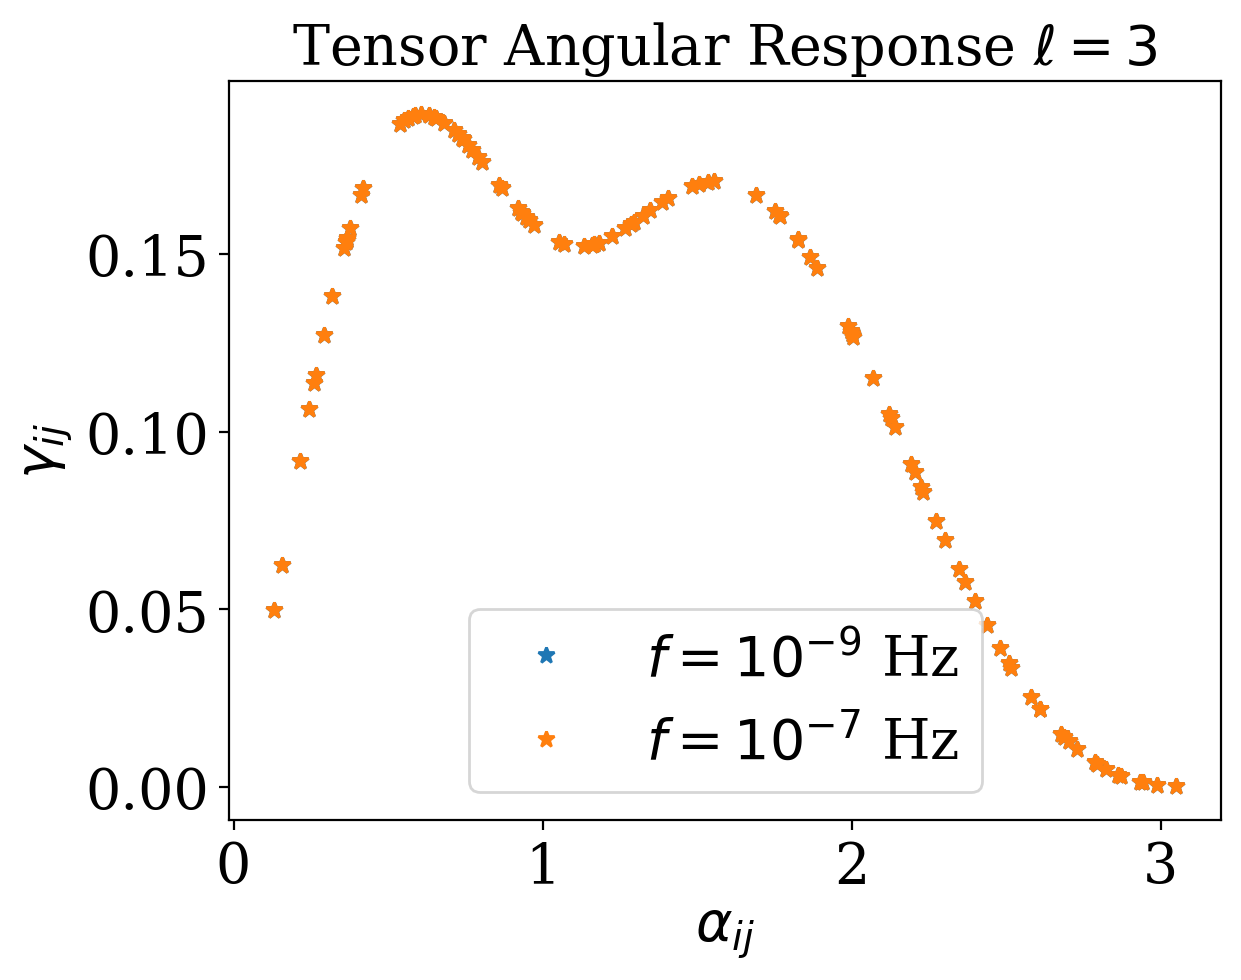

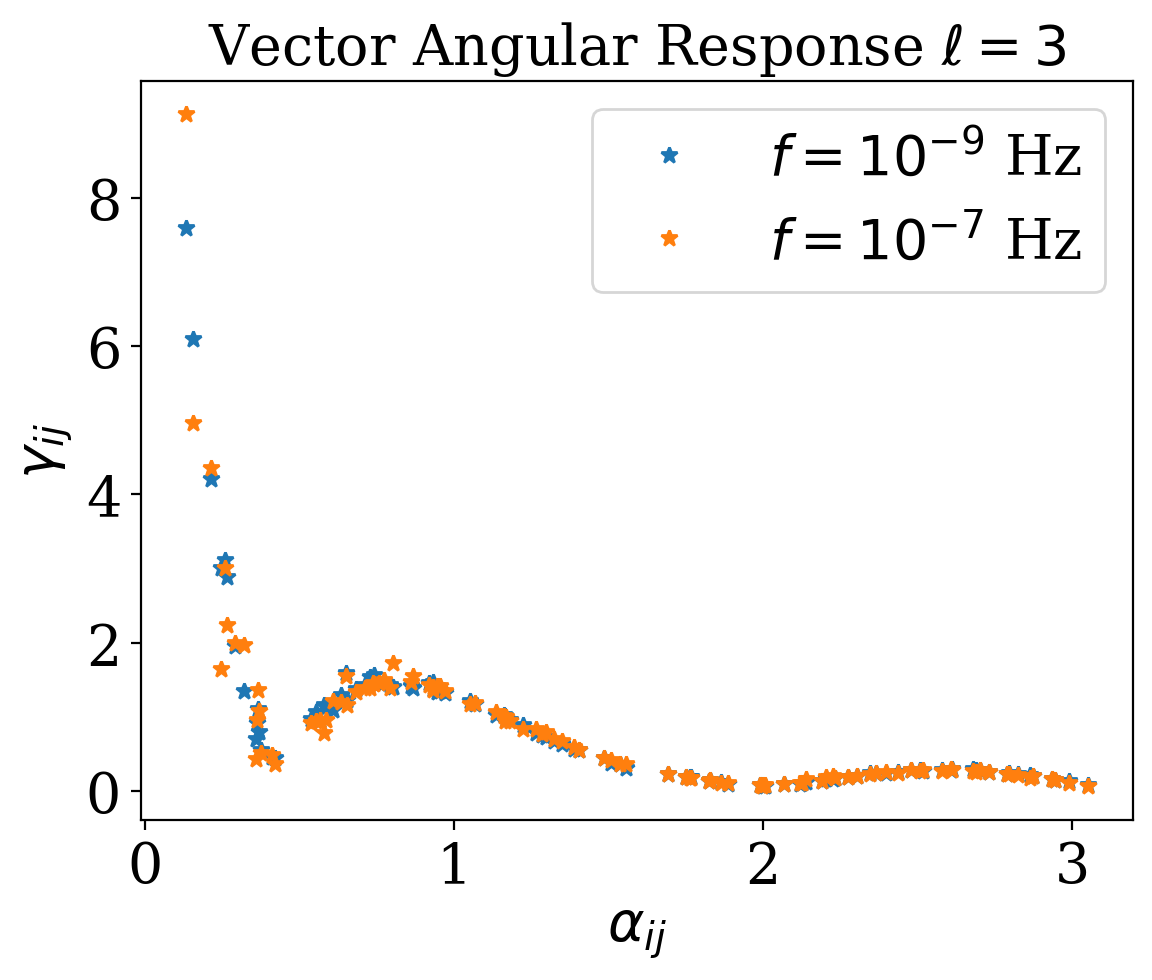

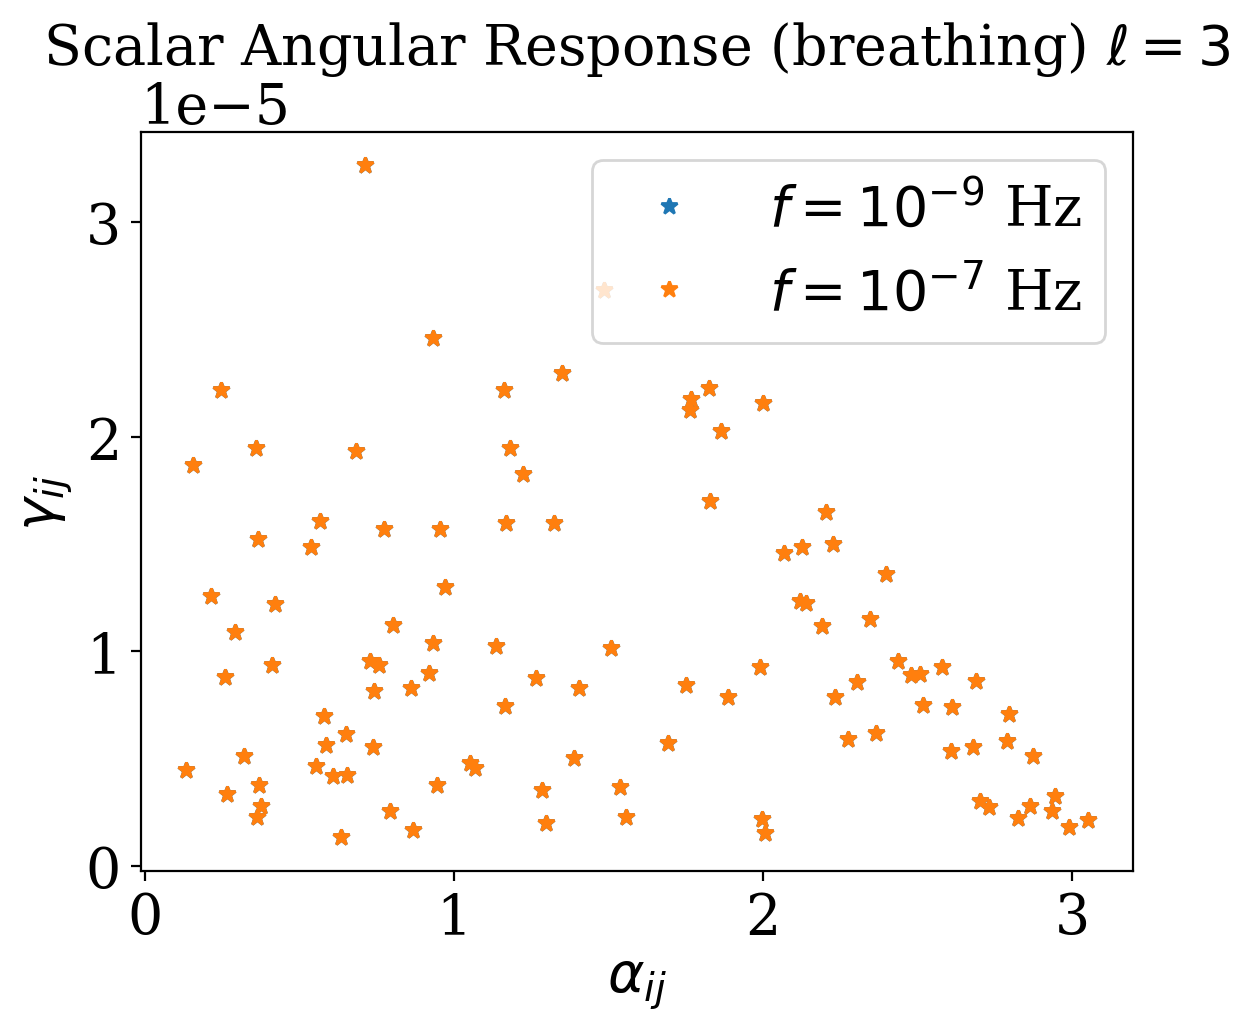

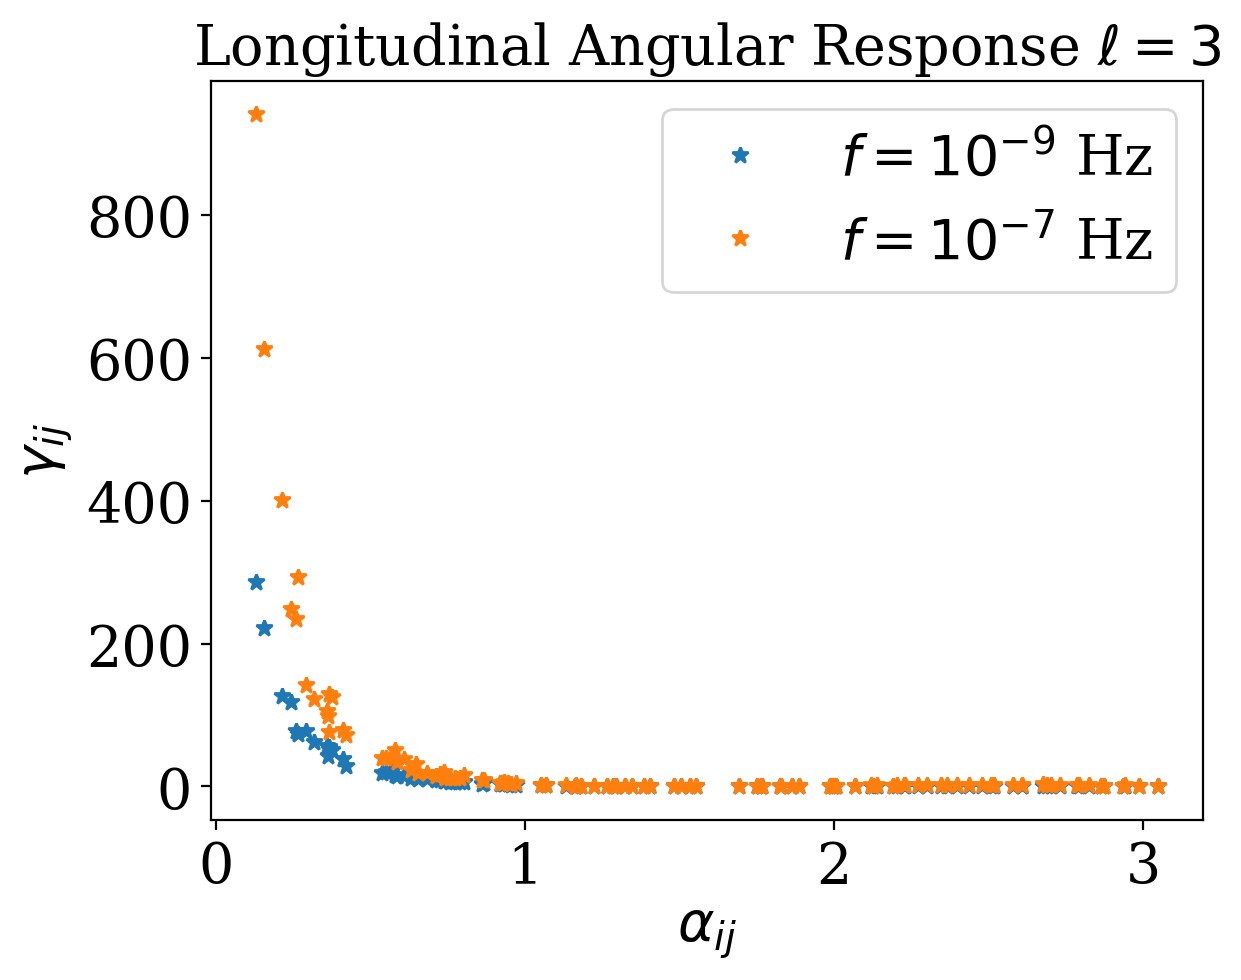

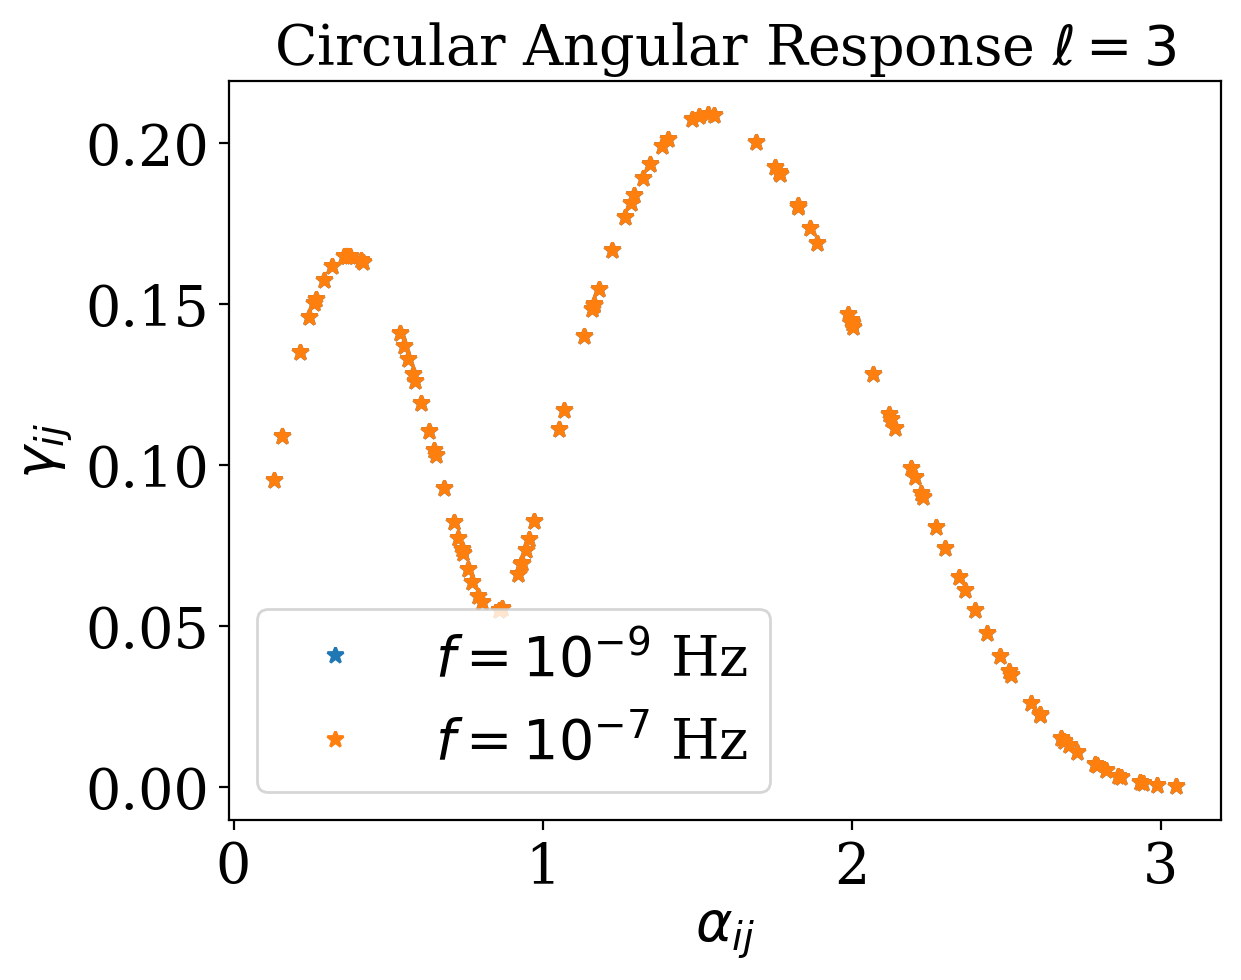

In [61]:
plt.plot(alpha_ij, gamma3_ij_t[:,0], '*', label='$f=10^{-9}$ Hz')
plt.plot(alpha_ij, gamma3_ij_t[:,-1], '*', label='$f=10^{-7}$ Hz')
plt.xlabel(r'$\alpha_{ij}$')
plt.ylabel(r'$\gamma_{ij}$')
plt.title('Tensor Angular Response $\ell=3$')
plt.legend()
plt.show()

plt.plot(alpha_ij, gamma3_ij_v[:,0], '*', label='$f=10^{-9}$ Hz')
plt.plot(alpha_ij, gamma3_ij_v[:,-1], '*', label='$f=10^{-7}$ Hz')
plt.xlabel(r'$\alpha_{ij}$')
plt.ylabel(r'$\gamma_{ij}$')
plt.title('Vector Angular Response $\ell=3$')
plt.legend()
plt.show()

plt.plot(alpha_ij, gamma3_ij_s[:,0], '*', label='$f=10^{-9}$ Hz')
plt.plot(alpha_ij, gamma3_ij_s[:,-1], '*', label='$f=10^{-7}$ Hz')
plt.xlabel(r'$\alpha_{ij}$')
plt.ylabel(r'$\gamma_{ij}$')
plt.title('Scalar Angular Response (breathing) $\ell=3$')
plt.legend()
plt.show()

plt.plot(alpha_ij, gamma3_ij_l[:,0], '*', label='$f=10^{-9}$ Hz')
plt.plot(alpha_ij, gamma3_ij_l[:,-1], '*', label='$f=10^{-7}$ Hz')
plt.xlabel(r'$\alpha_{ij}$')
plt.ylabel(r'$\gamma_{ij}$')
plt.title('Longitudinal Angular Response $\ell=3$')
plt.legend()
plt.show()

plt.plot(alpha_ij, gamma3_ij_V[:,0], '*', label='$f=10^{-9}$ Hz')
plt.plot(alpha_ij, gamma3_ij_V[:,-1], '*', label='$f=10^{-7}$ Hz')
plt.xlabel(r'$\alpha_{ij}$')
plt.ylabel(r'$\gamma_{ij}$')
plt.title('Circular Angular Response $\ell=3$') 
plt.legend()
plt.show()

In [62]:

f_index = np.argmin(np.abs(f - 1e-8))

gamma_ij_t_f_index = gamma_ij_t[:,f_index]
gamma_ij_v_f_index = gamma_ij_v[:,f_index]
gamma_ij_s_f_index = gamma_ij_s[:,f_index]
gamma_ij_l_f_index = gamma_ij_l[:,f_index]
gamma_ij_V_f_index = gamma_ij_V[:,f_index]

gamma1_ij_t_f_index = gamma1_ij_t[:,f_index]
gamma1_ij_v_f_index = gamma1_ij_v[:,f_index]
gamma1_ij_s_f_index = gamma1_ij_s[:,f_index]
gamma1_ij_l_f_index = gamma1_ij_l[:,f_index]
gamma1_ij_V_f_index = gamma1_ij_V[:,f_index]

gamma2_ij_t_f_index = gamma2_ij_t[:,f_index]
gamma2_ij_v_f_index = gamma2_ij_v[:,f_index]
gamma2_ij_s_f_index = gamma2_ij_s[:,f_index]
gamma2_ij_l_f_index = gamma2_ij_l[:,f_index]
gamma2_ij_V_f_index = gamma2_ij_V[:,f_index]

gamma3_ij_t_f_index = gamma3_ij_t[:,f_index]
gamma3_ij_v_f_index = gamma3_ij_v[:,f_index]
gamma3_ij_s_f_index = gamma3_ij_s[:,f_index]
gamma3_ij_l_f_index = gamma3_ij_l[:,f_index]
gamma3_ij_V_f_index = gamma3_ij_V[:,f_index]

# Reference expressions for generalized overlap reduction functions

In [63]:
# https://arxiv.org/pdf/1306.5394

# ell = 1 tensors

def R_1_1(alpha):
    term1 = -0.5* np.sqrt(np.pi/6)*np.sin(alpha)
    term2 =  3*(1-np.cos(alpha))
    term3 = (1 + 4/(1+np.cos(alpha))*np.log(np.sin(alpha/2)))
    return term1 * (1+term2*term3)


def R_11(alpha):
    return  -R_1_1(alpha) 


def R_10(alpha):
    term1 =-0.5 *np.sqrt(np.pi/3)
    term2 = 1+ np.cos(alpha)
    term3= 3 * (1-np.cos(alpha))
    term4 = 4*np.log(np.sin(alpha/2))
    return term1 * (term2 + term3 * (term2 + term4))

def R_1(alpha):
    term1 = R_1_1(alpha)
    term2 = R_11(alpha)
    term3 = R_10(alpha)
    return np.sqrt(term1**2 + term2**2 + term3**2)

# ell = 2 tensors

def R_22(alpha):
    term1 = -0.25 * np.sqrt(5*np.pi/6) * (1-np.cos(alpha))/(1+ cos(alpha))
    term2 = (1+ np.cos(alpha)) *((np.cos(alpha))**2 + 4* np.cos(alpha)-9)
    term3 = -24 * (1-cos(alpha)) * np.log(np.sin(alpha/2))
    return term1 * (term2 + term3)  

def R_21(alpha):
    term1 = 0.25*np.sqrt(2*np.pi/15)*np.sin(alpha)
    term2 = 5*(np.cos(alpha)**2) + 15*np.cos(alpha) -21
    term3 = -60*(1-np.cos(alpha))/(1+np.cos(alpha))*np.log(np.sin(alpha/2))
    return term1 * (term2 + term3)

def R_20(alpha):
    term1 = np.sqrt(np.pi/5)/3
    term2 = np.cos(alpha) 
    term3 = 15*(1-np.cos(alpha))/4
    term4 = (1+np.cos(alpha))*(np.cos(alpha)+3) + 8*np.log(np.sin(alpha/2))
    return term1*(term2 + term3*term4)

def R_2_2(alpha):
    return - R_22(alpha)

def R_2_1(alpha):
    return - R_21(alpha)

def R_2(alpha):
    term1 = R_2_2(alpha)
    term2 = R_2_1(alpha)
    term3 = R_20(alpha)
    term4 = R_21(alpha)
    term5 = R_22(alpha)
    return np.sqrt(term1**2 + term2**2 + term3**2 + term4**2 + term5**2)

# ell = 3 tensors

# checks with https://journals.aps.org/prd/pdf/10.1103/PhysRevD.93.062003 l = 3 appendix B

def R_3_3(alpha):
    term1 = -np.sqrt(35*np.pi)/48 * (1-np.cos(alpha))**2 /(np.sin(alpha))
    term2 = 34 - 17* np.cos(alpha) - 4*np.cos(alpha)**2 - np.cos(alpha)**3
    ratio = (1-np.cos(alpha))/(1+np.cos(alpha))
    term3 = 96 * ratio * np.log(np.sin(alpha/2))
    return term1 * (term2 + term3)

def R_3_2(alpha):
    term1 = - np.sqrt(210*np.pi)/48 * (1- np.cos(alpha))
    term2 = 17 - 9*np.cos(alpha) - 3*np.cos(alpha)**2 - np.cos(alpha)**3
    ratio = (1-np.cos(alpha))/(1+np.cos(alpha))
    term3 = 48 * ratio * np.log(np.sin(alpha/2))
    return term1 * (term2 + term3)

def R_3_1(alpha):
    term1 = - np.sqrt(21*np.pi)/48 * (1- np.cos(alpha)) * np.sin(alpha)
    term2 = 34 +15*np.cos(alpha) + 5*np.cos(alpha)**2
    term3 = 96/(1+np.cos(alpha)) * np.log(np.sin(alpha/2))
    return term1 * (term2 + term3)

def R_3_0(alpha):
    term1 = -np.sqrt(7*np.pi)/24 * (1-np.cos(alpha))
    term2 = (1+np.cos(alpha) )
    term3 = (17 + 10*np.cos(alpha) + 5*np.cos(alpha)**2 )
    term4 = 48 * np.log(np.sin(alpha/2))
    return term1 * (term2 * term3 + term4)

def R_31(alpha):
    return - R_3_1(alpha)

def R_32(alpha):
    return R_3_2(alpha)

def R_33(alpha):
    return - R_3_3(alpha)

def R_3(alpha):
    term1 = R_3_0(alpha)
    term2 = R_3_1(alpha)
    term3 = R_3_2(alpha)
    term4 = R_3_3(alpha)
    term5 = R_31(alpha)
    term6 = R_32(alpha)
    term7 = R_33(alpha)
    return np.sqrt(term1**2 + term2**2 + term3**2 + term4**2 + term5**2 + term6**2 + term7**2)


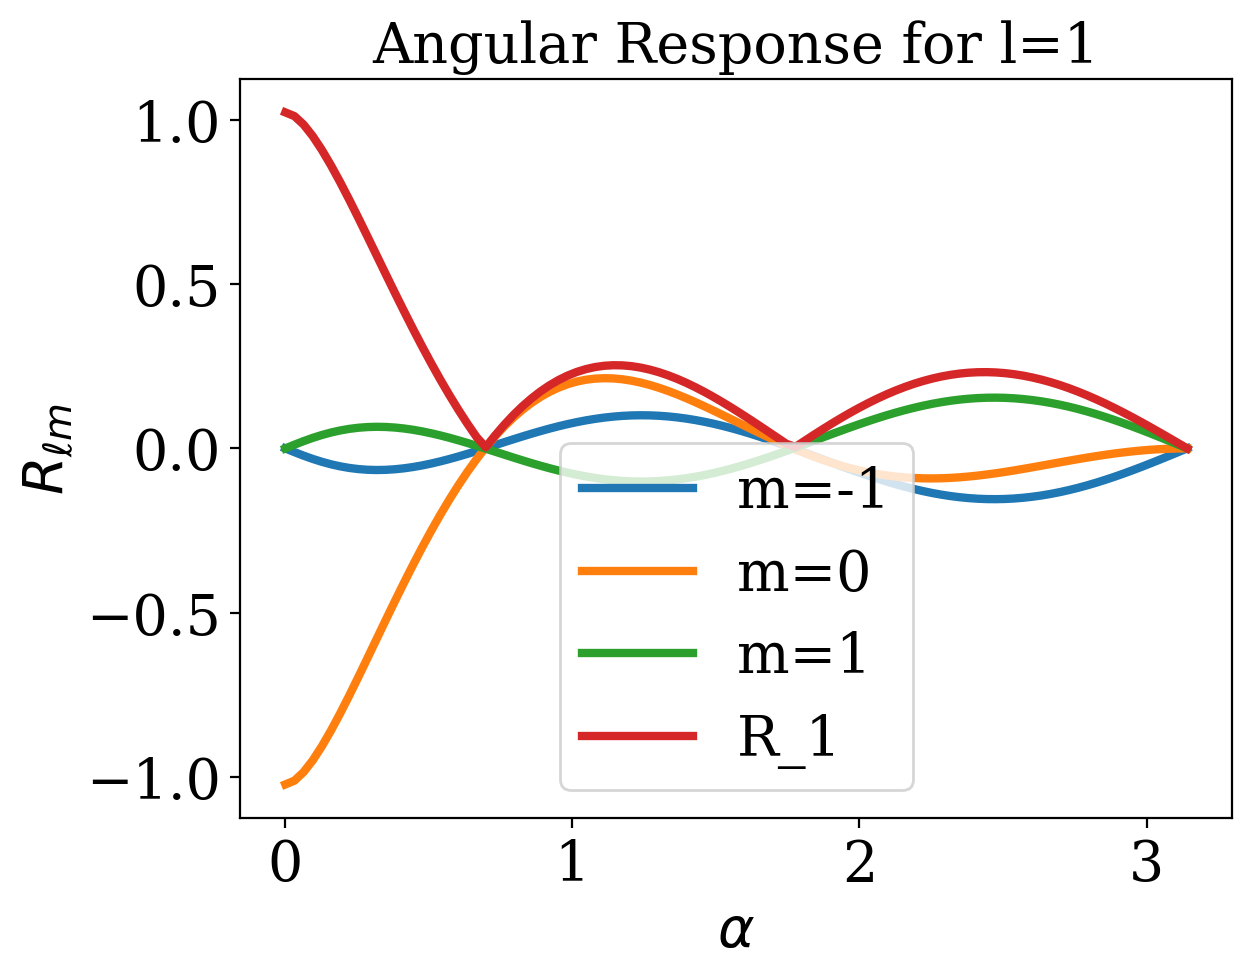

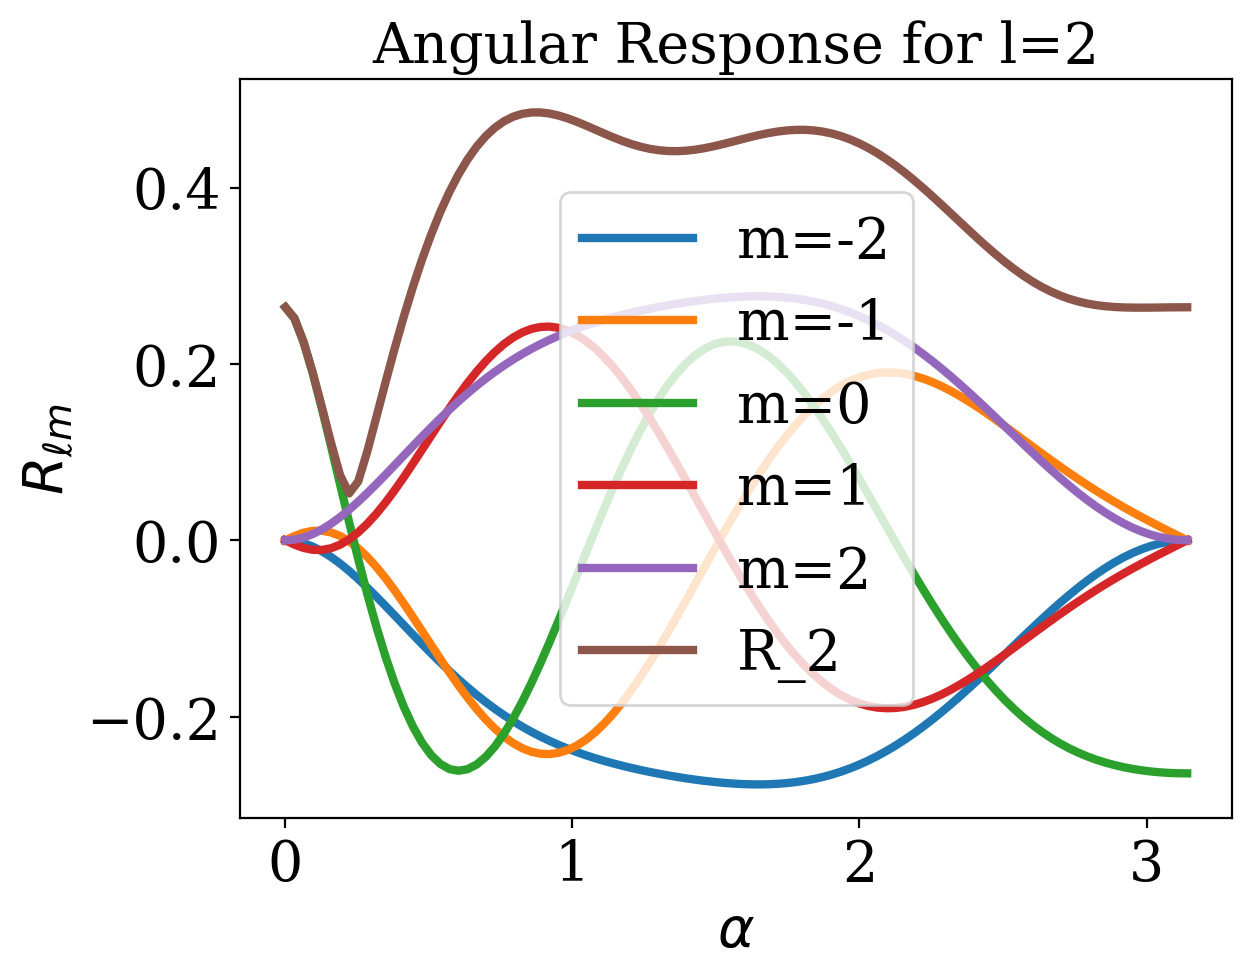

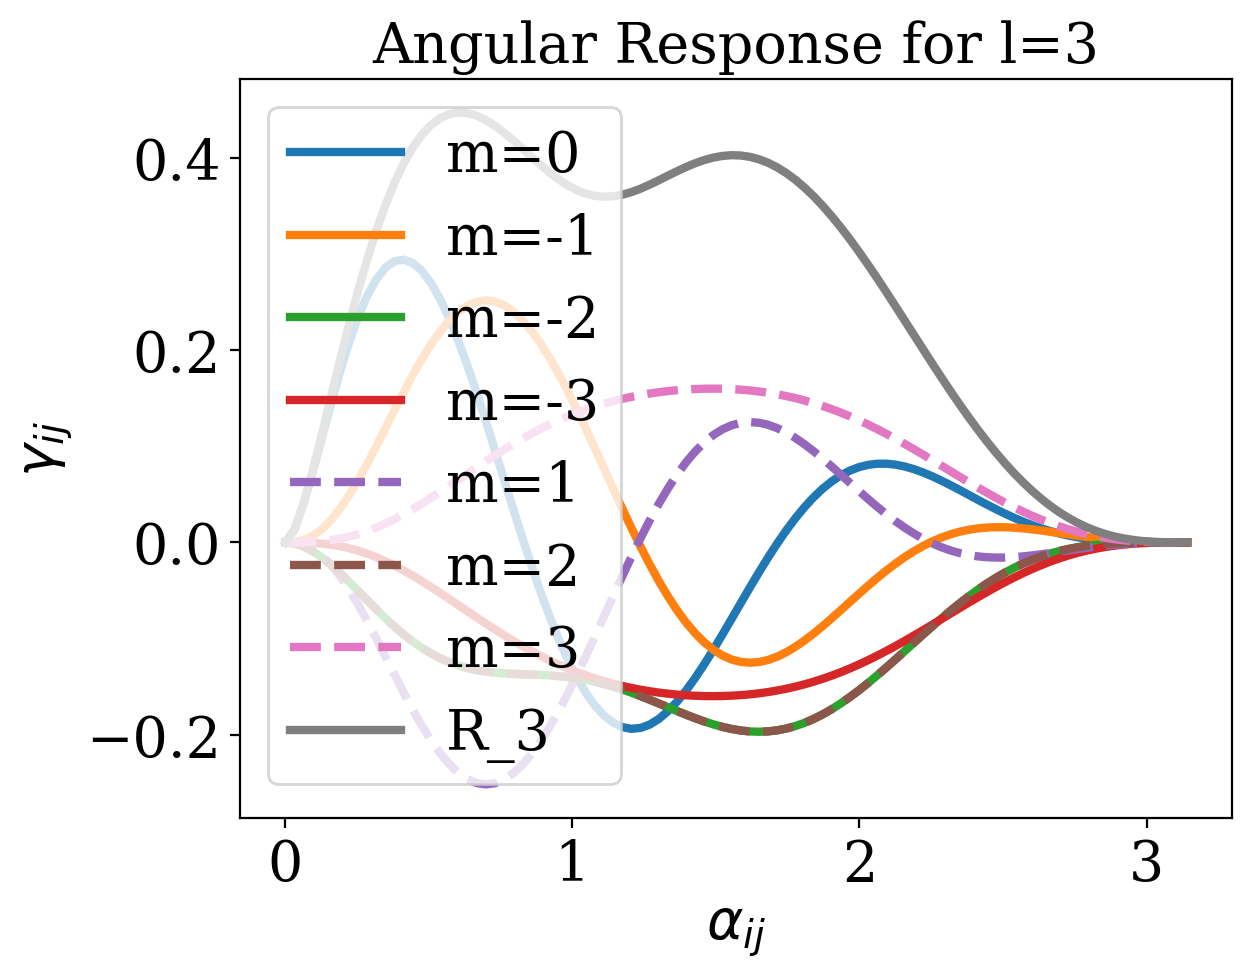

In [64]:
epsilon = 1e-5
alpha= np.linspace(epsilon, np.pi- epsilon, 100)

# l = 1 
plt.plot(alpha,R_1_1(alpha), label='m=-1' )
plt.plot(alpha, R_10(alpha), label='m=0')
plt.plot(alpha, R_11(alpha), label='m=1')
plt.plot(alpha, R_1(alpha), label='R_1')
plt.title('Angular Response for l=1')
plt.xlabel(r'$\alpha$')
plt.ylabel(r'$R_{\ell m}$')
plt.legend()
plt.show()

# l = 2 
plt.plot(alpha, R_2_2(alpha), label='m=-2')
plt.plot(alpha, R_2_1(alpha), label='m=-1')
plt.plot(alpha, R_20(alpha), label='m=0')
plt.plot(alpha, R_21(alpha), label='m=1')
plt.plot(alpha, R_22(alpha), label='m=2')
plt.plot(alpha, R_2(alpha), label='R_2')
plt.title('Angular Response for l=2')
plt.xlabel(r'$\alpha$')
plt.ylabel(r'$R_{\ell m}$')
plt.legend()
plt.show()


# l = 3

plt.plot(alpha, R_3_0(alpha), label='m=0')
plt.plot(alpha, R_3_1(alpha), label='m=-1')
plt.plot(alpha, R_3_2(alpha), label='m=-2')
plt.plot(alpha, R_3_3(alpha), label='m=-3')
plt.plot(alpha, R_31(alpha), label='m=1', linestyle='dashed')
plt.plot(alpha, R_32(alpha), label='m=2', linestyle='dashed')
plt.plot(alpha, R_33(alpha), label='m=3', linestyle='dashed')
plt.plot(alpha, R_3(alpha), label='R_3')
plt.legend()
plt.xlabel(r'$\alpha_{ij}$')
plt.ylabel(r'$\gamma_{ij}$')
plt.title('Angular Response for l=3')
plt.show()





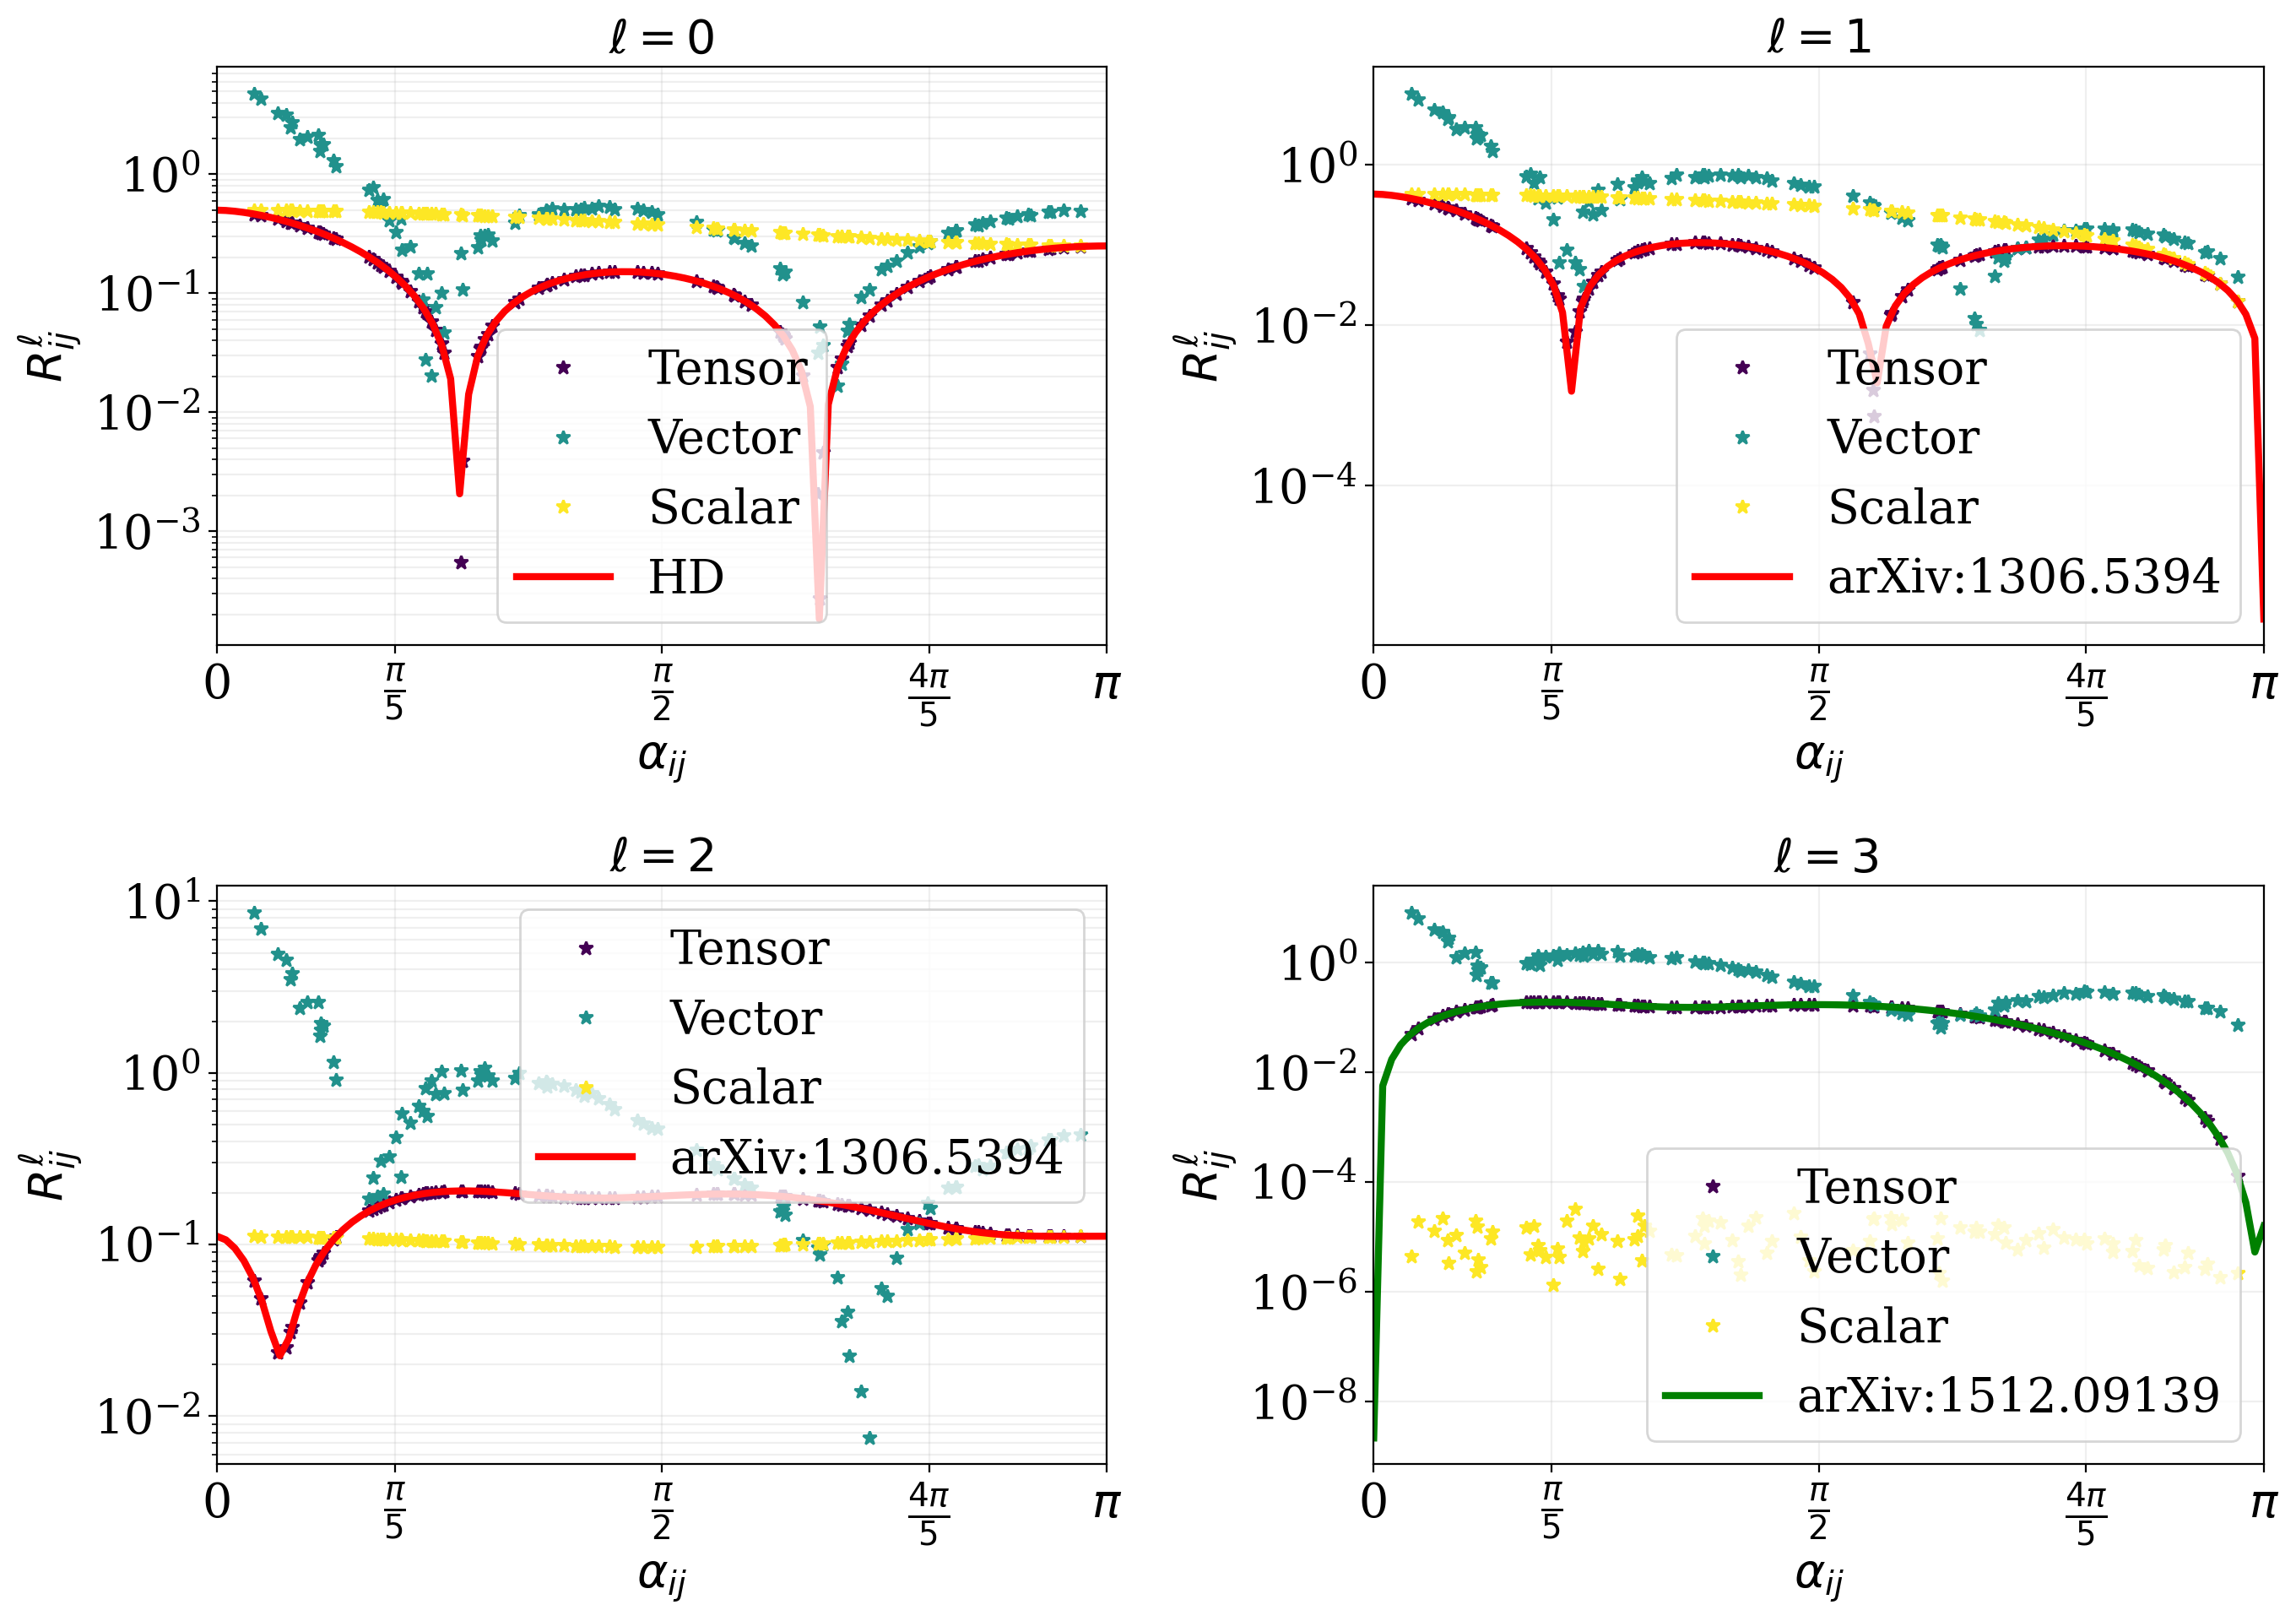

In [65]:
fig, ax = plt.subplots(2, 2, figsize=(14, 10))
 
# Plot per ℓ=0
ax[0, 0].semilogy(alpha_ij, np.abs(gamma_ij_t_f_index), '*', color=colors[0], label='Tensor')
ax[0, 0].semilogy(alpha_ij, np.abs(gamma_ij_v_f_index), '*', color=colors[1], label='Vector')
ax[0, 0].semilogy(alpha_ij, np.abs(gamma_ij_s_f_index), '*', color=colors[2], label='Scalar')
ax[0, 0].semilogy(alpha, np.abs(hellings_downs(alpha)), color='red', label='HD')
ax[0, 0].set_xlabel(r'$\alpha_{ij}$')
ax[0, 0].set_ylabel(r'$R_{ij}^{\ell}$')
ax[0, 0].grid(which='both', alpha=0.2)
ax[0, 0].set_title(r'$\ell=0$')
ax[0, 0].set_xticks(custom_ticks)
ax[0, 0].set_xlim(0, np.pi)
ax[0, 0].legend()
ax[0, 0].xaxis.set_major_formatter(FuncFormatter(custom_pi_formatter))

# Plot per ℓ=1
ax[0, 1].semilogy(alpha_ij, gamma1_ij_t_f_index, '*', color=colors[0], label='Tensor')
ax[0, 1].semilogy(alpha_ij, gamma1_ij_v_f_index, '*', color=colors[1], label='Vector')
ax[0, 1].semilogy(alpha_ij, gamma1_ij_s_f_index, '*', color=colors[2], label='Scalar')
ax[0, 1].semilogy(alpha, 3*np.sqrt(4*np.pi)/(8*np.pi)* R_1(alpha), color='red', label='arXiv:1306.5394')
ax[0, 1].set_xlabel(r'$\alpha_{ij}$')
ax[0, 1].set_ylabel(r'$R_{ij}^{\ell}$')
ax[0, 1].grid(which='both', alpha=0.2)
ax[0, 1].set_title(r'$\ell=1$')
ax[0, 1].set_xticks(custom_ticks)
ax[0, 1].set_xlim(0, np.pi)
ax[0, 1].legend()
ax[0, 1].xaxis.set_major_formatter(FuncFormatter(custom_pi_formatter))

# Plot per ℓ=2
ax[1, 0].semilogy(alpha_ij, gamma2_ij_t_f_index, '*', color=colors[0], label='Tensor')
ax[1, 0].semilogy(alpha_ij, gamma2_ij_v_f_index, '*', color=colors[1], label='Vector')
ax[1, 0].semilogy(alpha_ij, gamma2_ij_s_f_index, '*', color=colors[2], label='Scalar')
ax[1, 0].semilogy(alpha, 3*np.sqrt(4*np.pi)/(8*np.pi)*R_2(alpha), color='red', label='arXiv:1306.5394')
ax[1, 0].set_xlabel(r'$\alpha_{ij}$')
ax[1, 0].set_ylabel(r'$R_{ij}^{\ell}$')
ax[1, 0].grid(which='both', alpha=0.2)
ax[1, 0].set_title(r'$\ell=2$')
ax[1, 0].set_xticks(custom_ticks)
ax[1, 0].legend()
ax[1, 0].set_xlim(0, np.pi)
ax[1, 0].xaxis.set_major_formatter(FuncFormatter(custom_pi_formatter))

# Plot per ℓ=3
ax[1, 1].semilogy(alpha_ij, gamma3_ij_t_f_index, '*', color=colors[0], label='Tensor')
ax[1, 1].semilogy(alpha_ij, gamma3_ij_v_f_index, '*', color=colors[1], label='Vector')
ax[1, 1].semilogy(alpha_ij, gamma3_ij_s_f_index, '*', color=colors[2], label='Scalar')
ax[1, 1].semilogy(alpha, 3*np.sqrt(4*np.pi)/(8*np.pi)*R_3(alpha), color='green', label='arXiv:1512.09139')
ax[1, 1].set_xlabel(r'$\alpha_{ij}$')
ax[1, 1].set_ylabel(r'$R_{ij}^{\ell}$')
ax[1, 1].grid(which='both', alpha=0.2)
ax[1, 1].set_title(r' $\ell=3$')
ax[1, 1].set_xticks(custom_ticks)
ax[1, 1].legend()
ax[1, 1].set_xlim(0, np.pi)
ax[1, 1].xaxis.set_major_formatter(FuncFormatter(custom_pi_formatter))

plt.tight_layout()
plt.show()

circular polarization

In [66]:
# functions to check the angular response https://journals.aps.org/prd/pdf/10.1103/PhysRevD.93.062003

# l=0
def RV_0(alpha):
    return np.zeros(len(alpha))

# l=1
def RV_1_1(alpha):
    return - np.sqrt(6*np.pi)/3 * np.sin(alpha) * ( 1 + 3*((1-np.cos(alpha))/(1+np.cos(alpha)))*np.log(np.sin(alpha/2)) )

def RV_11(alpha):
    return RV_1_1(alpha)

def RV_10(alpha):
    return np.zeros(len(alpha))

def RV_1(alpha):
    term1 = RV_1_1(alpha)
    term2 = RV_11(alpha)
    term3 = RV_10(alpha)
    return np.sqrt(term1**2 + term2**2 + term3**2)

# l=2
def RV_2_2(alpha):
    term1 = np.sqrt(30*np.pi)/6 * (1- np.cos(alpha))
    term2 = (2 - np.cos(alpha))
    term3 = 6 * ((1- np.cos(alpha))/(1+ np.cos(alpha))) * np.log(np.sin(alpha/2))
    return term1* (term2 + term3)

def RV_2_1(alpha):
    term1 = np.sqrt(30*np.pi)/6 * (np.sin(alpha)/(1+ np.cos(alpha)))
    term2 = 2
    term3 = (1- np.cos(alpha))
    term4 = (np.cos(alpha) + 6* np.log(np.sin(alpha/2)))
    return term1* (term2 + term3*term4)

def RV_20(alpha):
    return np.zeros(len(alpha))

def RV_21(alpha):
    return RV_2_1(alpha)

def RV_22(alpha):
    return -RV_2_2(alpha)

def RV_2(alpha):
    term1 = RV_2_2(alpha)
    term2 = RV_2_1(alpha)
    term3 = RV_20(alpha)
    term4 = RV_21(alpha)
    term5 = RV_22(alpha)
    return np.sqrt(term1**2 + term2**2 + term3**2 + term4**2 + term5**2)

# l = 3

def RV_3_3(alpha):
    ratio = (1-np.cos(alpha))/(1+np.cos(alpha))
    term1 = - np.sqrt(35*np.pi)/16 * np.sin(alpha) * ratio
    term2 = 11 - 6*np.cos(alpha) - np.cos(alpha)**2
    term3 = 32 * ratio * np.log(np.sin(alpha/2))
    return term1 * (term2 + term3)

def RV_3_2(alpha):
    term1 = - np.sqrt(210*np.pi)/24 * (1 - np.cos(alpha))
    term2 = 8 - 5*np.cos(alpha) - np.cos(alpha)**2
    ratio = (1-np.cos(alpha))/(1+np.cos(alpha))
    term3 = 24*ratio*np.log(np.sin(alpha/2))
    return term1 * (term2 + term3)

def RV_3_1(alpha):
    term1 = - np.sqrt(21*np.pi)/48 * np.sin(alpha)
    term2 = 33 - 20*np.cos(alpha) - 5*np.cos(alpha)**2
    ratio = (1-np.cos(alpha))/(1+np.cos(alpha))
    term3 = 96* ratio *np.log(np.sin(alpha/2))
    return term1 * (term2 + term3)

def RV_3_0(alpha):
    return np.zeros(len(alpha))

def RV_31(alpha):
    return RV_3_1(alpha)

def RV_32(alpha):
    return -RV_3_2(alpha)

def RV_33(alpha):
    return RV_3_3(alpha)

def RV_3(alpha):
    term1 = RV_3_3(alpha)
    term2 = RV_3_2(alpha)
    term3 = RV_3_1(alpha)
    term4 = RV_3_0(alpha)
    term5 = RV_31(alpha)
    term6 = RV_32(alpha)
    term7 = RV_33(alpha)
    return np.sqrt(term1**2 + term2**2 + term3**2 + term4**2 + term5**2 + term6**2 + term7**2)


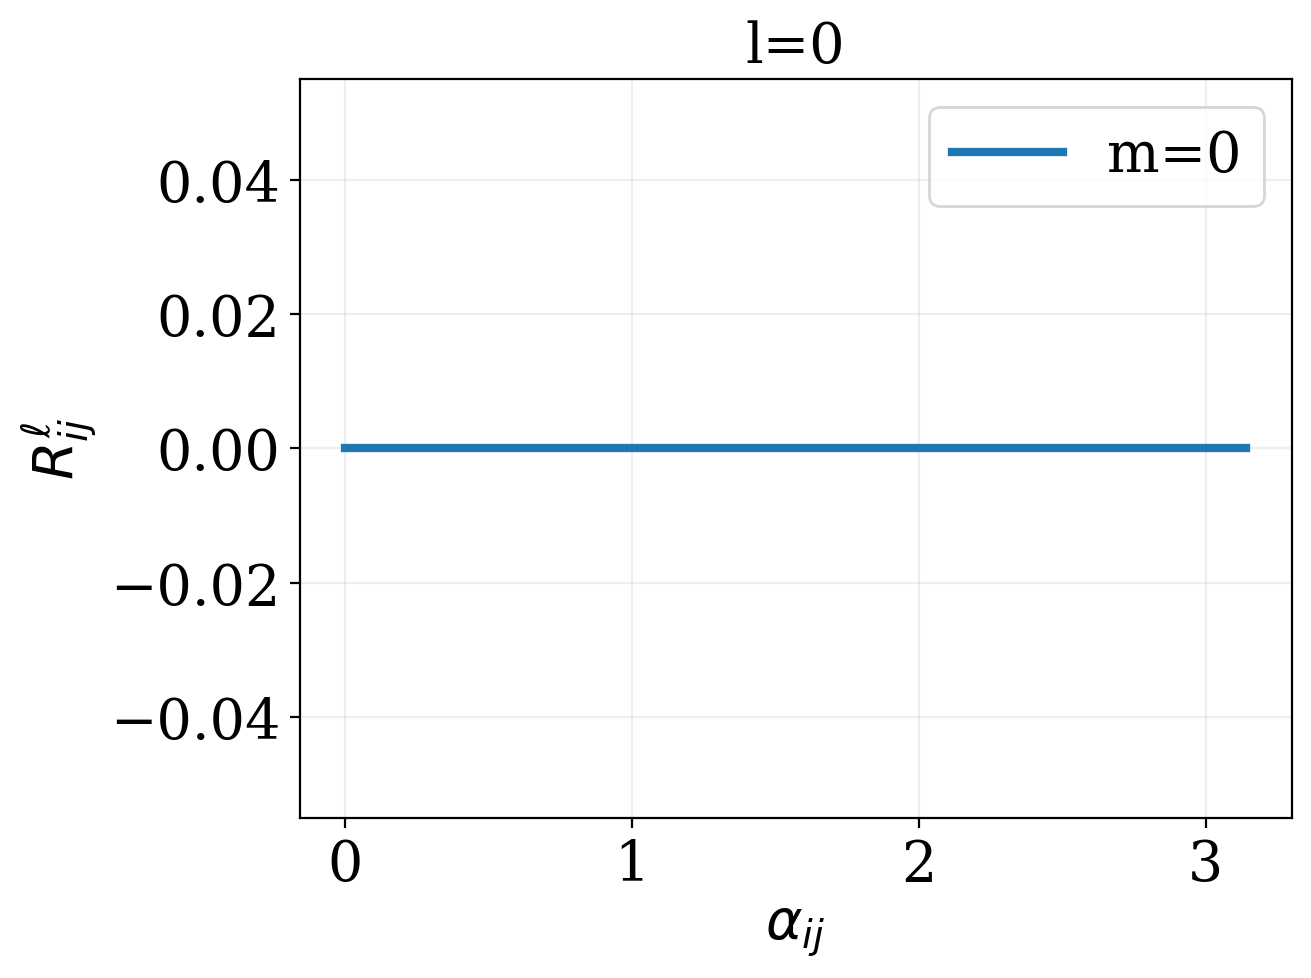

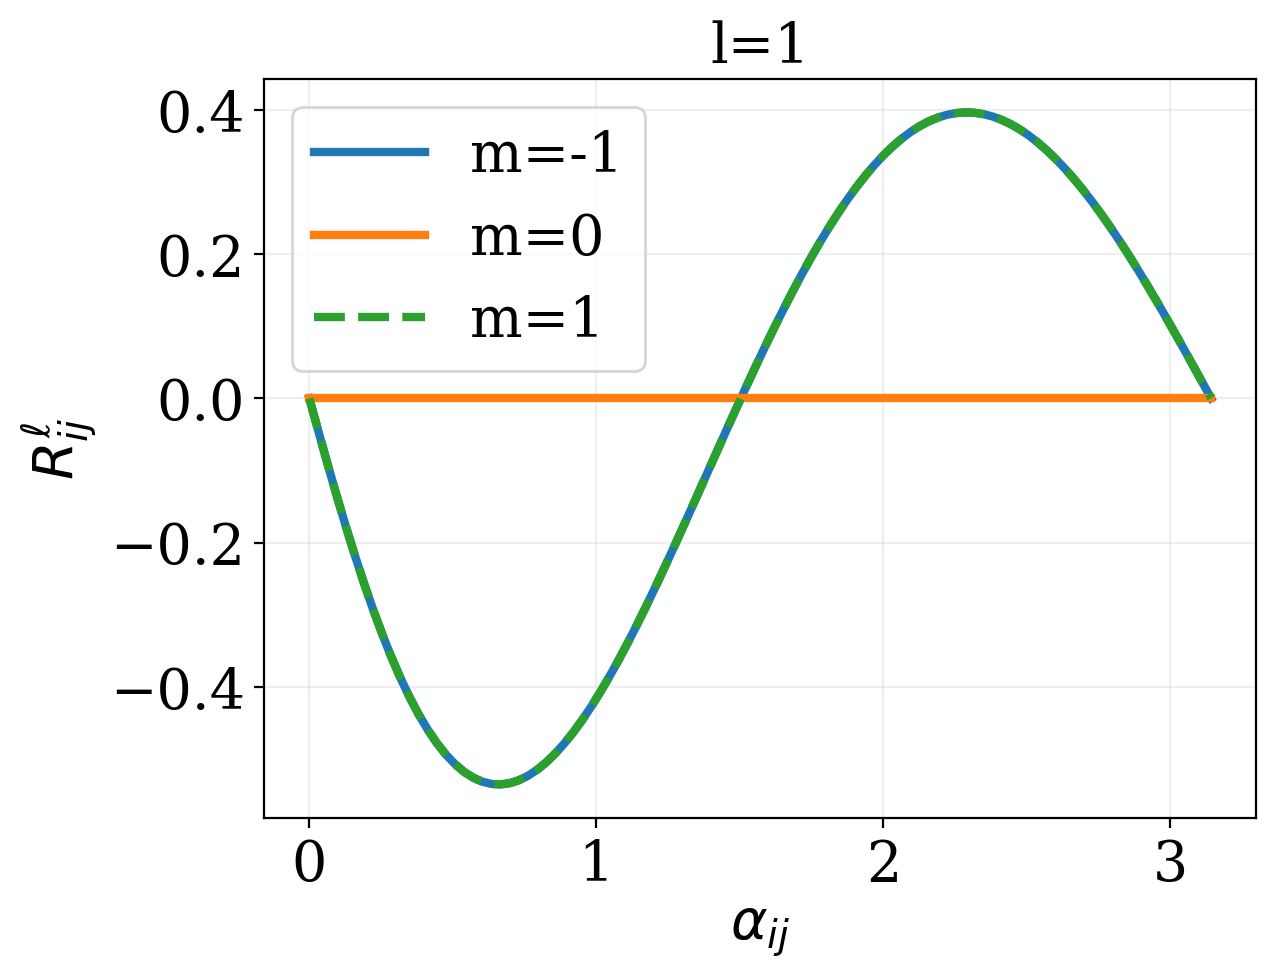

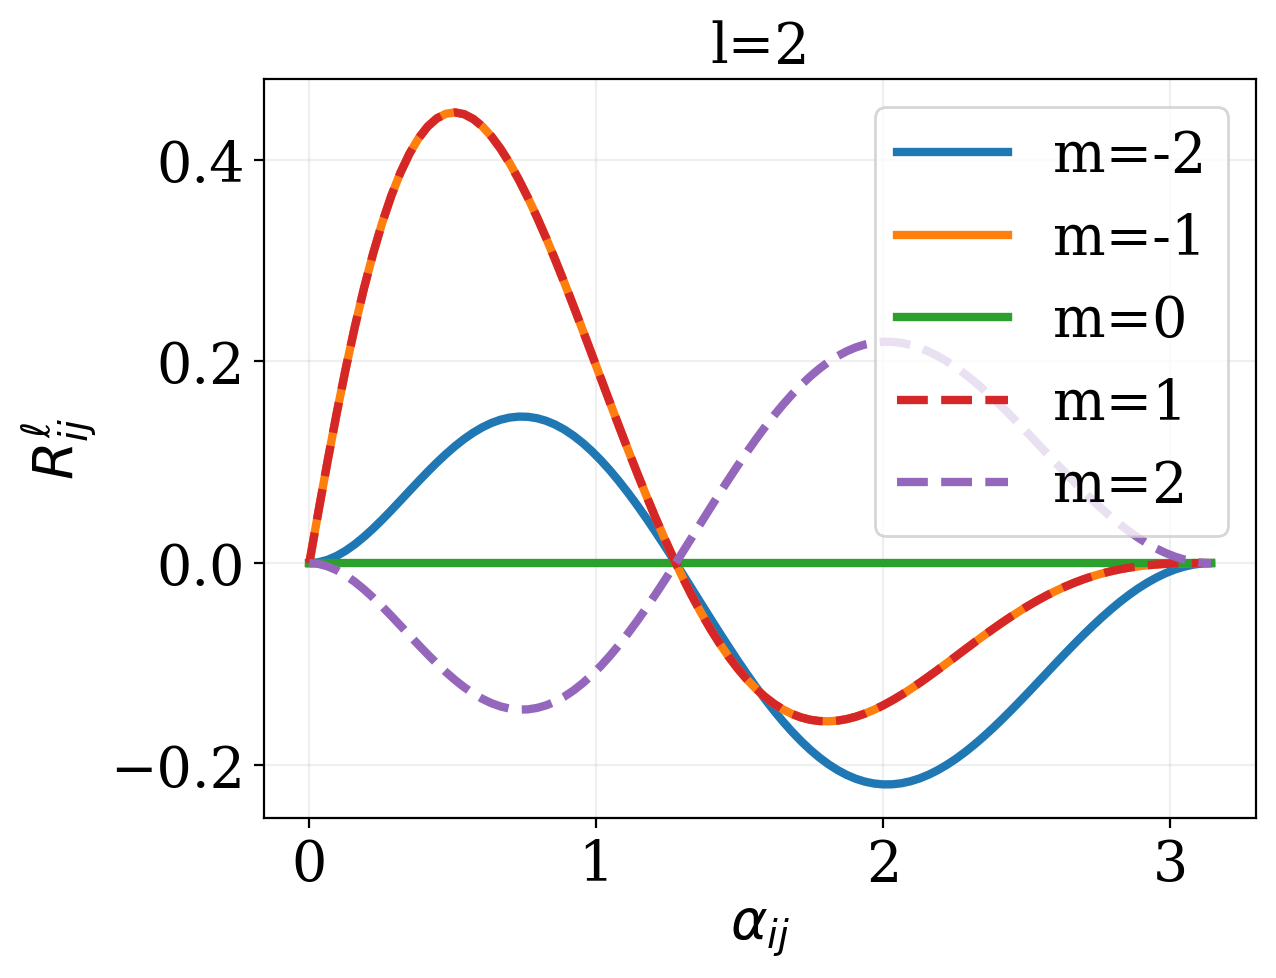

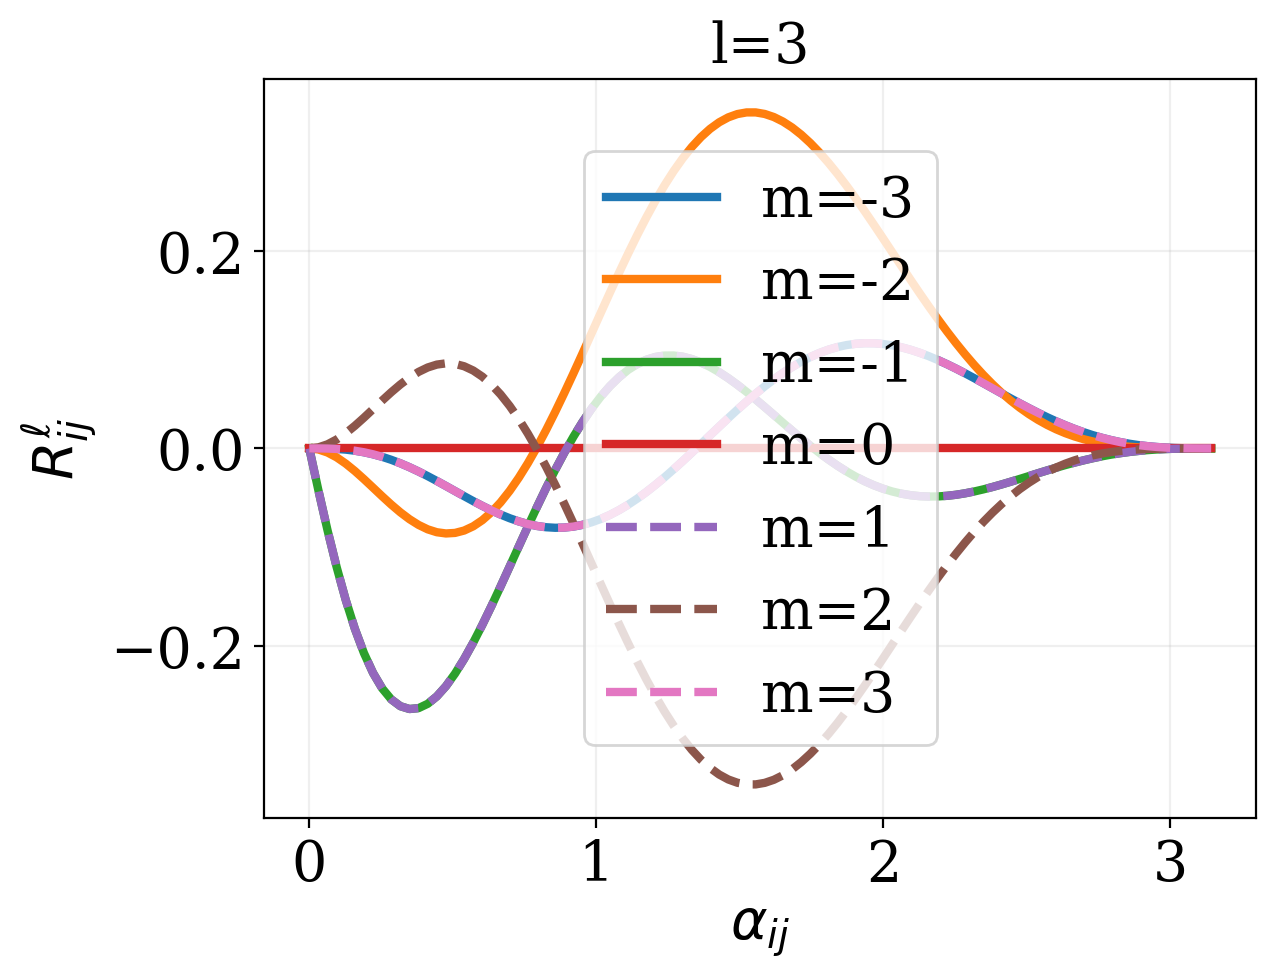

In [67]:
alpha = np.linspace(epsilon, np.pi - epsilon, 100)

# l = 0

plt.plot(alpha, RV_0(alpha), label='m=0')
plt.xlabel(r'$\alpha_{ij}$')
plt.ylabel(r'$R_{ij}^{\ell}$')
plt.title('l=0')
plt.grid(which='both', alpha=0.2)
plt.legend()
plt.show()

# l = 1
plt.plot(alpha, RV_1_1(alpha), label='m=-1')
plt.plot(alpha, RV_10(alpha), label='m=0')
plt.plot(alpha, RV_11(alpha), label='m=1', linestyle = '--')
plt.xlabel(r'$\alpha_{ij}$')
plt.ylabel(r'$R_{ij}^{\ell}$')
plt.title('l=1')
plt.grid(which='both', alpha=0.2)
plt.legend()
plt.show()

# l = 2
plt.plot(alpha, RV_2_2(alpha), label='m=-2')
plt.plot(alpha, RV_2_1(alpha), label='m=-1')
plt.plot(alpha, RV_20(alpha), label='m=0')
plt.plot(alpha, RV_21(alpha), label='m=1', linestyle = '--')
plt.plot(alpha, RV_22(alpha), label='m=2', linestyle = '--')
plt.xlabel(r'$\alpha_{ij}$')
plt.ylabel(r'$R_{ij}^{\ell}$')
plt.title('l=2')
plt.grid(which='both', alpha=0.2)
plt.legend()
plt.show()

# l = 3
plt.plot(alpha, RV_3_3(alpha), label='m=-3')
plt.plot(alpha, RV_3_2(alpha), label='m=-2')
plt.plot(alpha, RV_3_1(alpha), label='m=-1')
plt.plot(alpha, RV_3_0(alpha), label='m=0')
plt.plot(alpha, RV_31(alpha), label='m=1', linestyle = '--')
plt.plot(alpha, RV_32(alpha), label='m=2', linestyle = '--')
plt.plot(alpha, RV_33(alpha), label='m=3', linestyle = '--')
plt.xlabel(r'$\alpha_{ij}$')
plt.ylabel(r'$R_{ij}^{\ell}$')
plt.title('l=3')
plt.grid(which='both', alpha=0.2)
plt.legend()
plt.show()


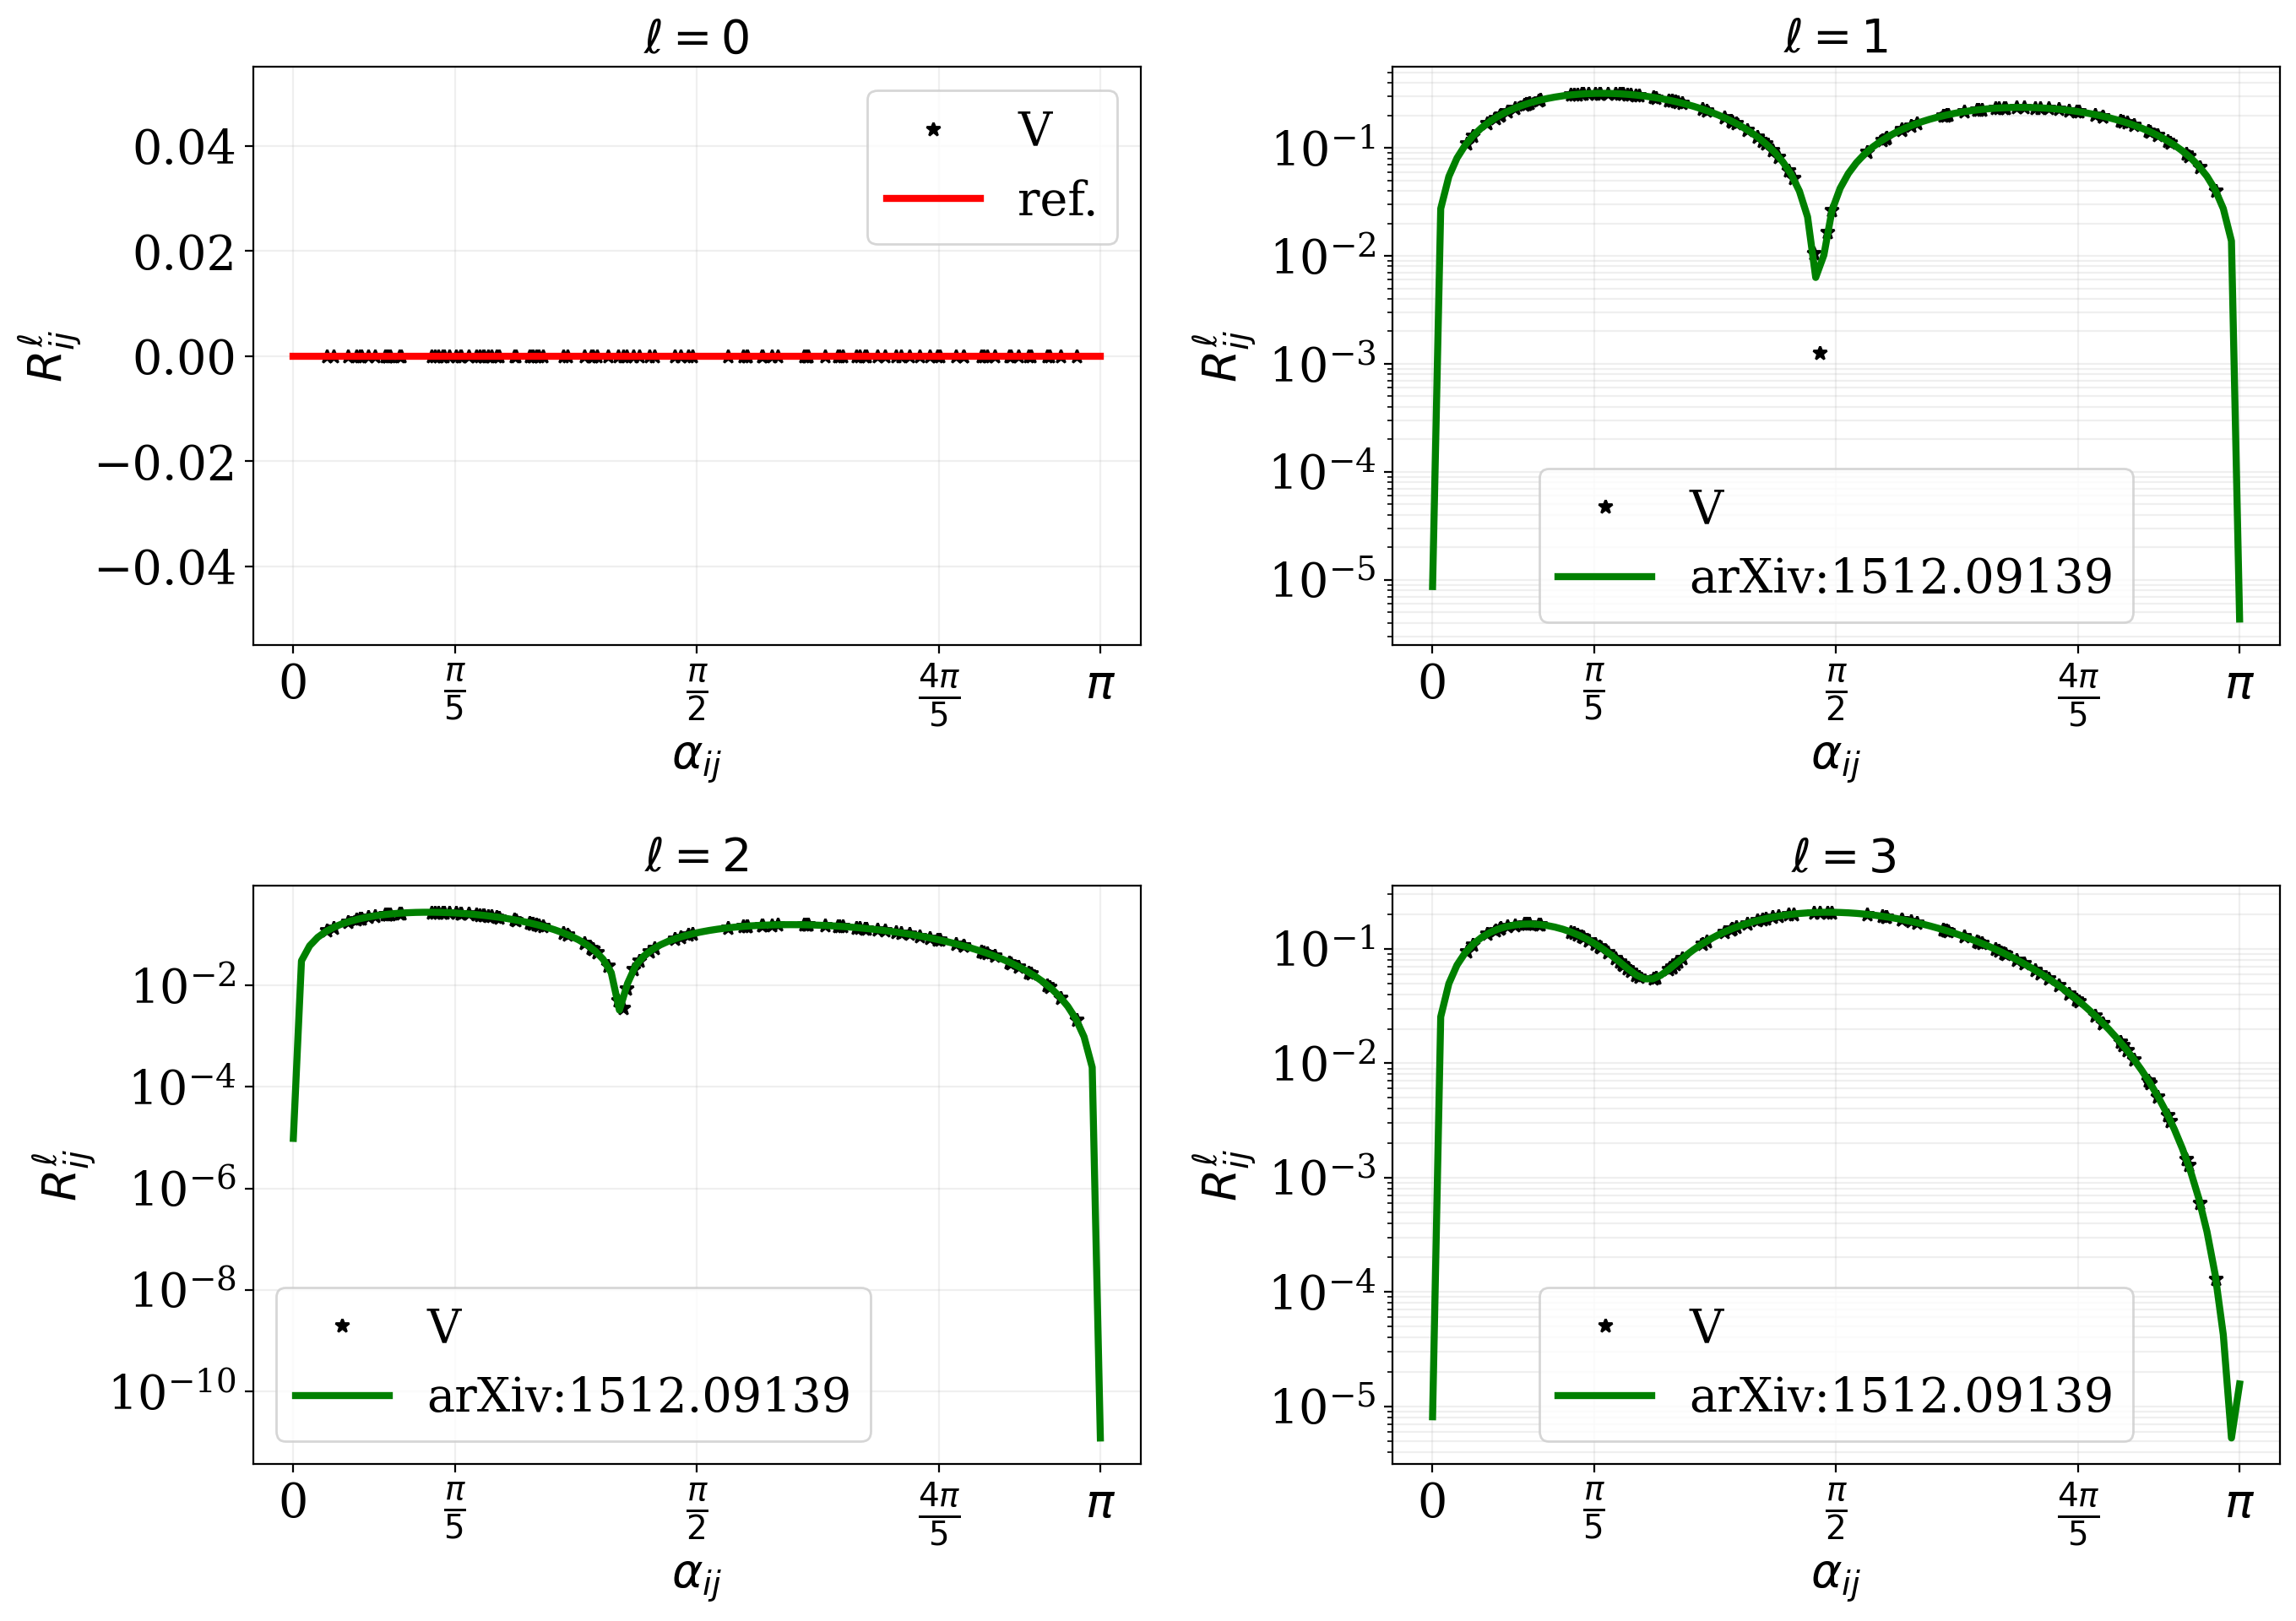

In [71]:
# plot

# plot 2x2 dove in ogni blocco c'è un multipolo

fig, ax = plt.subplots(2, 2, figsize=(14, 10))

# Definizione dei tick personalizzati


norm = 3*np.sqrt(4*np.pi)/(8*np.pi)

# Plot per ℓ=0
ax[0, 0].plot(alpha_ij, np.abs(gamma_ij_V_f_index), '*', color='black', label='V')
ax[0, 0].plot(alpha, norm*np.abs(RV_0(alpha)), color='red', label='ref.')
ax[0, 0].set_xlabel(r'$\alpha_{ij}$')
ax[0, 0].set_ylabel(r'$R_{ij}^{\ell}$')
ax[0, 0].grid(which='both', alpha=0.2)
ax[0, 0].set_title(r'$\ell=0$')
ax[0, 0].set_xticks(custom_ticks)
ax[0, 0].legend()
ax[0, 0].xaxis.set_major_formatter(FuncFormatter(custom_pi_formatter))

# Plot per ℓ=1
ax[0, 1].semilogy(alpha_ij, gamma1_ij_V_f_index, '*', color='black', label='V')
ax[0, 1].semilogy(alpha, norm*RV_1(alpha), color='green', label='arXiv:1512.09139')
ax[0, 1].set_xlabel(r'$\alpha_{ij}$')
ax[0, 1].set_ylabel(r'$R_{ij}^{\ell}$')
ax[0, 1].grid(which='both', alpha=0.2)
ax[0, 1].set_title(r'$\ell=1$')
ax[0, 1].set_xticks(custom_ticks)
ax[0, 1].legend()
ax[0, 1].xaxis.set_major_formatter(FuncFormatter(custom_pi_formatter))

# Plot per ℓ=2
ax[1, 0].semilogy(alpha_ij, gamma2_ij_V_f_index, '*', color='black', label='V')
ax[1, 0].semilogy(alpha, norm*RV_2(alpha), color='green', label='arXiv:1512.09139')
ax[1, 0].set_xlabel(r'$\alpha_{ij}$')
ax[1, 0].set_ylabel(r'$R_{ij}^{\ell}$')
ax[1, 0].grid(which='both', alpha=0.2)
ax[1, 0].set_title(r'$\ell=2$')
ax[1, 0].set_xticks(custom_ticks)
ax[1, 0].legend()
ax[1, 0].xaxis.set_major_formatter(FuncFormatter(custom_pi_formatter))

# Plot per ℓ=3
ax[1, 1].semilogy(alpha_ij, gamma3_ij_V_f_index, '*', color='black', label='V')
ax[1, 1].semilogy(alpha, norm*RV_3(alpha), color='green', label='arXiv:1512.09139')
ax[1, 1].set_xlabel(r'$\alpha_{ij}$')
ax[1, 1].set_ylabel(r'$R_{ij}^{\ell}$')
ax[1, 1].grid(which='both', alpha=0.2)
ax[1, 1].set_title(r' $\ell=3$')
ax[1, 1].set_xticks(custom_ticks)
ax[1, 1].legend()
ax[1, 1].xaxis.set_major_formatter(FuncFormatter(custom_pi_formatter))

plt.tight_layout()
plt.show()
